In [1]:
! pip -q install pandas matplotlib==3.7.* numpy seaborn
! pip install -q scikit-learn
! pip install -q joblib
! pip install -q tensorflow


[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Bidirectional, BatchNormalization, Input
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import pandas as pd
import joblib
import os

pd.set_option('display.max_columns', None)

train_df_raw = pd.read_csv("data/train.csv")
train_calendar_df_raw = pd.read_csv("data/train_calendar.csv")
test_df_raw = pd.read_csv("data/test.csv")
test_calendar_df_raw = pd.read_csv("data/test_calendar.csv")

train_df_raw['date'] = pd.to_datetime(train_df_raw['date'])
train_calendar_df_raw['date'] = pd.to_datetime(train_calendar_df_raw['date'])
test_df_raw['date'] = pd.to_datetime(test_df_raw['date'])
test_calendar_df_raw['date'] = pd.to_datetime(test_calendar_df_raw['date'])

### Optional Dataset Validation

Evaluate the data correctness. Check both .csvs if their values in the same columns match and then merge them into one dataset.

In [3]:
def merge_csv(train_df, train_calendar_df):
    # Identify common columns
    common_columns = set(train_df.columns).intersection(set(train_calendar_df.columns))
    print(common_columns)

    # Merg the two datasets on warehouse and date
    merged_df_to_test = pd.merge(train_df, train_calendar_df, on=['date', 'warehouse'], suffixes=('_train', '_calendar'))
    
        # Compare values in common columns
    differences = {}
    for column in common_columns:
        if column not in ['date', 'warehouse']:  # Exclude join keys from comparison
            train_col = f"{column}_train"
            calendar_col = f"{column}_calendar"
            
            # Check if there are any differences, excluding rows where both values are NaN
            diff = merged_df_to_test[(merged_df_to_test[train_col] != merged_df_to_test[calendar_col]) & 
                            (~merged_df_to_test[train_col].isna() | ~merged_df_to_test[calendar_col].isna())]
            if not diff.empty:
                differences[column] = diff[['date', 'warehouse', train_col, calendar_col]]
            else:
                print(f"No differences found in column: {column}")

    # Display only the rows where values were different
    for col, diff in differences.items():
        print(f"\nNot merged. Differences found in column: {col}")
        print(diff)
        return

    if not differences:
        print("\nSuccess. All values match across the datasets, datasets merged.")
        return pd.merge(train_df, train_calendar_df, on=list(common_columns))


In [4]:
# Merg the two datasets on 'date' and 'warehouse' to facilitate comparison
train_df_merged = merge_csv(train_df_raw, train_calendar_df_raw)
test_df_merged = merge_csv(test_df_raw, test_calendar_df_raw) 

{'mov_change', 'precipitation', 'holiday_name', 'holiday', 'shutdown', 'frankfurt_shutdown', 'warehouse', 'winter_school_holidays', 'date', 'mini_shutdown', 'snow', 'school_holidays', 'blackout', 'shops_closed'}
No differences found in column: mov_change
No differences found in column: precipitation
No differences found in column: holiday_name
No differences found in column: holiday
No differences found in column: shutdown
No differences found in column: frankfurt_shutdown
No differences found in column: winter_school_holidays
No differences found in column: mini_shutdown
No differences found in column: snow
No differences found in column: school_holidays
No differences found in column: blackout
No differences found in column: shops_closed

Success. All values match across the datasets, datasets merged.
{'holiday_name', 'holiday', 'warehouse', 'winter_school_holidays', 'date', 'school_holidays', 'shops_closed'}
No differences found in column: holiday_name
No differences found in column

In [5]:
train_df = train_df_merged.sort_values(by=['date', 'warehouse'])
test_df = test_df_merged.sort_values(by=['date', 'warehouse'])

### Drop unnecesary data

There are some data in the training set that will not be availiable in the testing / inference data inputs.

In [6]:
# get features that are not available in the test dataset
unavailable_features = list(set(train_df.columns).difference(set(test_df.columns)))    
unavailable_features.remove('orders')

print(f"Common features: {unavailable_features}")

Common features: ['mov_change', 'precipitation', 'shutdown', 'frankfurt_shutdown', 'mini_shutdown', 'snow', 'blackout', 'warehouse_limited', 'user_activity_2', 'user_activity_1']


In [7]:
train_df = train_df.drop(columns=unavailable_features)

In [8]:
# list redundant columns that have unchanging values
unchanging_columns = []
for column in train_df.columns:
    if train_df[column].nunique() == 1:
        unchanging_columns.append(column)
print(unchanging_columns)

train_df = train_df.drop(columns=unchanging_columns)

[]


In [9]:
print(train_df.columns)
print(f"train data: {train_df.shape}")
print(f"test data: {test_df.shape}")

Index(['warehouse', 'date', 'orders', 'holiday_name', 'holiday',
       'shops_closed', 'winter_school_holidays', 'school_holidays', 'id'],
      dtype='object')
train data: (7340, 9)
test data: (397, 8)


In [10]:
print(train_df.isnull().sum())
print(test_df.isnull().sum())

warehouse                    0
date                         0
orders                       0
holiday_name              7122
holiday                      0
shops_closed                 0
winter_school_holidays       0
school_holidays              0
id                           0
dtype: int64
warehouse                   0
date                        0
holiday_name              380
holiday                     0
shops_closed                0
winter_school_holidays      0
school_holidays             0
id                          0
dtype: int64


In [11]:
test_df.head()

warehouse       date holiday_name  holiday  shops_closed  \
61        Brno_1 2024-03-16          NaN        0             0   
340   Budapest_1 2024-03-16          NaN        0             0   
292  Frankfurt_1 2024-03-16          NaN        0             0   
244     Munich_1 2024-03-16          NaN        0             0   
0       Prague_1 2024-03-16          NaN        0             0   

     winter_school_holidays  school_holidays                      id  
61                        0                0       Brno_1_2024-03-16  
340                       0                0   Budapest_1_2024-03-16  
292                       0                0  Frankfurt_1_2024-03-16  
244                       0                0     Munich_1_2024-03-16  
0                         0                0     Prague_1_2024-03-16

In [12]:
# What is the gap between the date of the last training data and the first test data?
train_max_date = train_df['date'].max()
test_min_date = test_df['date'].min()
print(f"Train max date: {train_max_date}")
print(f"Test min date: {test_min_date}")
print(f"Gap: {test_min_date - train_max_date}")

Train max date: 2024-03-15 00:00:00
Test min date: 2024-03-16 00:00:00
Gap: 1 days 00:00:00


In [13]:
# merge the two datasets to facilitate data preprocessing and lag features generation   
train_df = pd.concat([train_df, test_df], axis=0)

In [14]:
train_df = train_df.sort_values(by=['date', 'warehouse'])

In [15]:
train_df.head(10)

warehouse       date  orders holiday_name  holiday  shops_closed  \
1193      Brno_1 2020-12-05  6447.0          NaN        0             0   
6186  Budapest_1 2020-12-05  4623.0          NaN        0             0   
0       Prague_1 2020-12-05  6895.0          NaN        0             0   
2386    Prague_2 2020-12-05  4154.0          NaN        0             0   
3579    Prague_3 2020-12-05  4091.0          NaN        0             0   
1194      Brno_1 2020-12-06  5338.0          NaN        0             0   
6187  Budapest_1 2020-12-06  4197.0          NaN        0             0   
1       Prague_1 2020-12-06  6584.0          NaN        0             0   
2387    Prague_2 2020-12-06  4016.0          NaN        0             0   
3580    Prague_3 2020-12-06  3972.0          NaN        0             0   

      winter_school_holidays  school_holidays                     id  
1193                       0                0      Brno_1_2020-12-05  
6186                       0                0  Budapest_1_2020-12-05  
0                          0                0    Prague_1_2020-12-05  
2386                       0                0    Prague_2_2020-12-05  
3579                       0                0    Prague_3_2020-12-05  
1194                       0                0      Brno_1_2020-12-06  
6187                       0                0  Budapest_1_2020-12-06  
1                          0                0    Prague_1_2020-12-06  
2387                       0                0    Prague_2_2020-12-06  
3580                       0                0    Prague_3_2020-12-06

In [16]:
from math import pi

def process_date(df):
    df.index = df.pop('date')
    
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['day_of_week'] = df.index.dayofweek
    df['day_of_year'] = df.index.dayofyear
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    
    df['days_since_start'] = (df.index - df.index.min()).days
    
    df['year_sin'] = df['year'] * np.sin(2 * pi * df['year'])
    df['year_cos'] = df['year'] * np.cos(2 * pi * df['year'])
    df['month_sin'] = df['month'] * np.sin(2 * pi * df['month'])
    df['month_cos'] = df['month'] * np.cos(2 * pi * df['month'])
    #df['day_sin'] = df['day'] * np.sin(2 * pi * df['day'])
    #df['day_cos'] = df['day'] * np.cos(2 * pi * df['day'])
    
    time_features = ['day', 'days_since_start', 'month', 'day_of_year', 'year_sin', 'year_cos', 'month_sin', 'month_cos']
    categorical_features = ['day_of_week', 'quarter', 'year'] 
    binary_features = ['is_weekend']
    return df, time_features, categorical_features, binary_features

### Features categories:
- time_features
- numerical_features
- categorical_features

In [17]:
train_df, time_features, categorical_features, binary_features=process_date(train_df)
binary_features = binary_features + ['holiday', 'shops_closed', 'winter_school_holidays', 'school_holidays']

In [18]:
train_df = train_df.drop(columns=['holiday_name']) 

### Plot

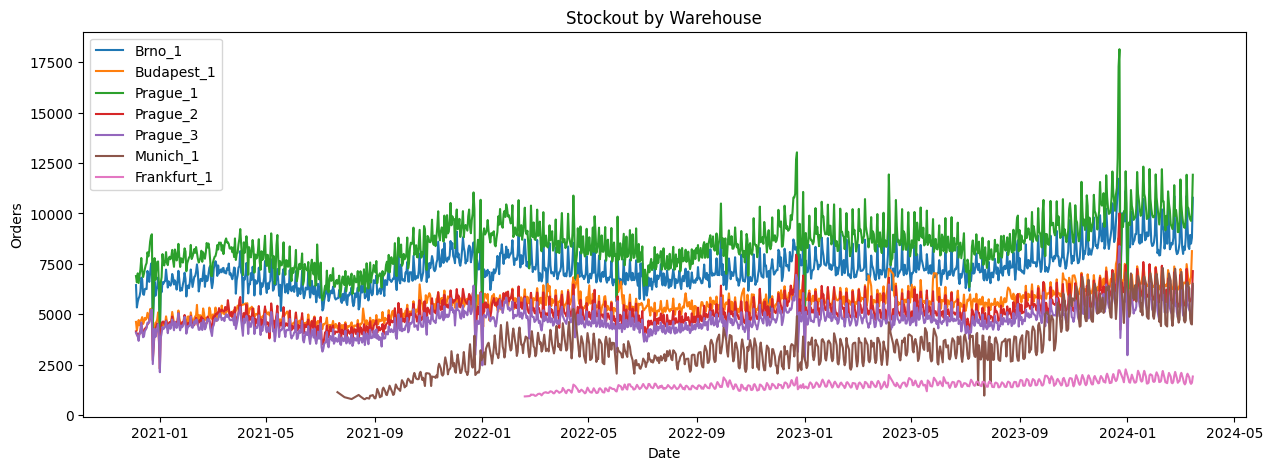

In [19]:
# Visualise the data
plt.figure(figsize=(15, 5))
for warehouse in train_df['warehouse'].unique():
    warehouse_df = train_df[train_df['warehouse'] == warehouse]
    plt.plot(warehouse_df.index, warehouse_df['orders'], label=warehouse)
plt.title("Stockout by Warehouse")
plt.xlabel("Date")
plt.ylabel("Orders")
plt.legend()
plt.show()

<Axes: title={'center': 'Distribution'}, xlabel='Orders', ylabel='Frequency'>

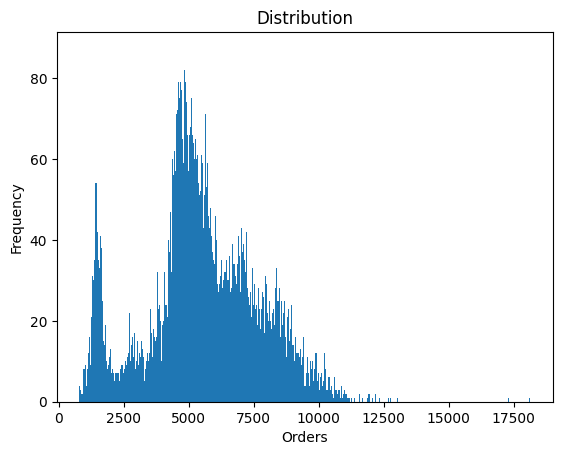

In [20]:
train_df['orders'].plot(kind='hist', bins=500, title='Distribution', xlabel='Orders')

<Axes: xlabel='date'>

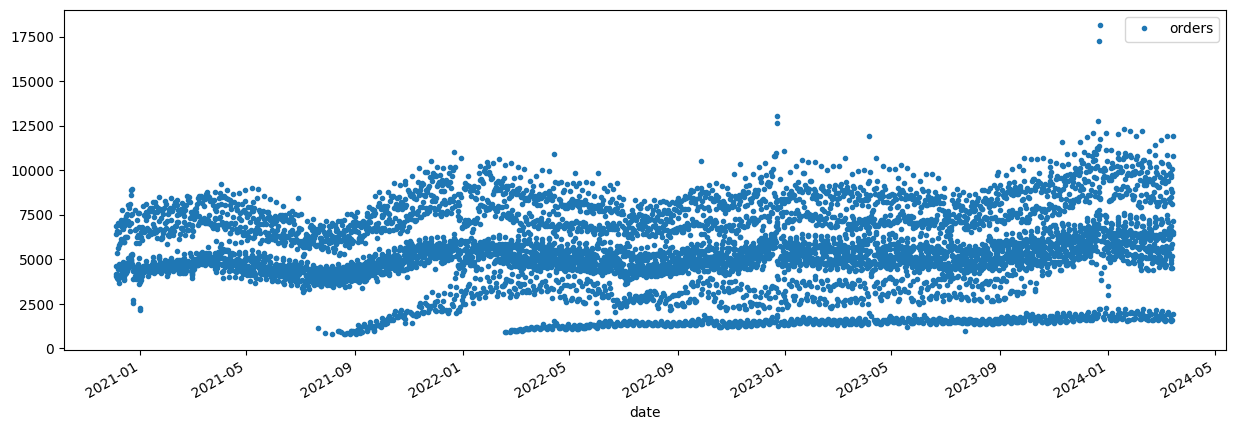

In [21]:
train_df.query('orders > 500').plot(y='orders', figsize=(15, 5), style='.')

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def z_score_outlier_detection(data, window=14, threshold=3):
    data = data.sort_index()
    rolling_mean = data.rolling(window=window, center=True, min_periods=1).mean()
    rolling_std = data.rolling(window=window, center=True, min_periods=1).std()
    z_scores = (data - rolling_mean) / rolling_std
    outliers = np.abs(z_scores) > threshold
    lower_bound = rolling_mean - (threshold * rolling_std)
    upper_bound = rolling_mean + (threshold * rolling_std)
    return outliers, lower_bound, upper_bound

def fix_outliers(data, outliers, window=14):
    fixed_data = data.copy()
    fixed_data[outliers] = np.nan
    fixed_data = fixed_data.interpolate()
    return fixed_data

def plot_outlier_comparison(train_df, window=28, z_threshold=3):
    warehouses = train_df['warehouse'].unique()
    n_warehouses = len(warehouses)
    
    n_cols = 1
    n_rows = n_warehouses
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 10*n_rows))
    axes = axes.flatten() if n_warehouses > 1 else [axes]
    
    all_z_outliers = pd.Series(dtype=bool)
    
    for idx, warehouse in enumerate(warehouses):
        warehouse_data = train_df[train_df['warehouse'] == warehouse]['orders']
        
        z_outliers, z_lower, z_upper = z_score_outlier_detection(warehouse_data, window, z_threshold)
        fixed_warehouse_data = fix_outliers(warehouse_data, z_outliers, window=window)
        
        # Update the original DataFrame with fixed values
        train_df.loc[train_df['warehouse'] == warehouse, 'orders'] = fixed_warehouse_data
        
        all_z_outliers = pd.concat([all_z_outliers, z_outliers])
        
        # Plot the original data and outliers
        ax = axes[idx]
        ax.plot(warehouse_data.index, warehouse_data, label='Orders', alpha=0.7)
        
        # Plot Z-Score bounds and outliers
        ax.fill_between(warehouse_data.index, z_lower, z_upper, color='green', alpha=0.1, label='Z-Score Bounds')
        ax.scatter(warehouse_data.index[z_outliers], warehouse_data[z_outliers], color='green', label='Z-Score Outliers', marker='s')
        
        # Plot fixed outliers
        ax.scatter(warehouse_data.index[z_outliers], fixed_warehouse_data[z_outliers], color='orange', label='Fixed Outliers', marker='x')

        ax.set_title(f'{warehouse} - Outlier Comparison')
        ax.set_xlabel('Date')
        ax.set_ylabel('Orders')
        ax.legend()
        ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary of outliers for each warehouse
    for warehouse in warehouses:
        warehouse_data = train_df[train_df['warehouse'] == warehouse]['orders']
        z_outliers, _, _ = z_score_outlier_detection(warehouse_data, window, z_threshold)
        
        print(f"\n{warehouse}:")
        print(f"Z-Score Outliers: {sum(z_outliers)}")
    
    return train_df




C:\Users\ondre\AppData\Local\Temp\ipykernel_16852\1434646546.py:43: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  all_z_outliers = pd.concat([all_z_outliers, z_outliers])


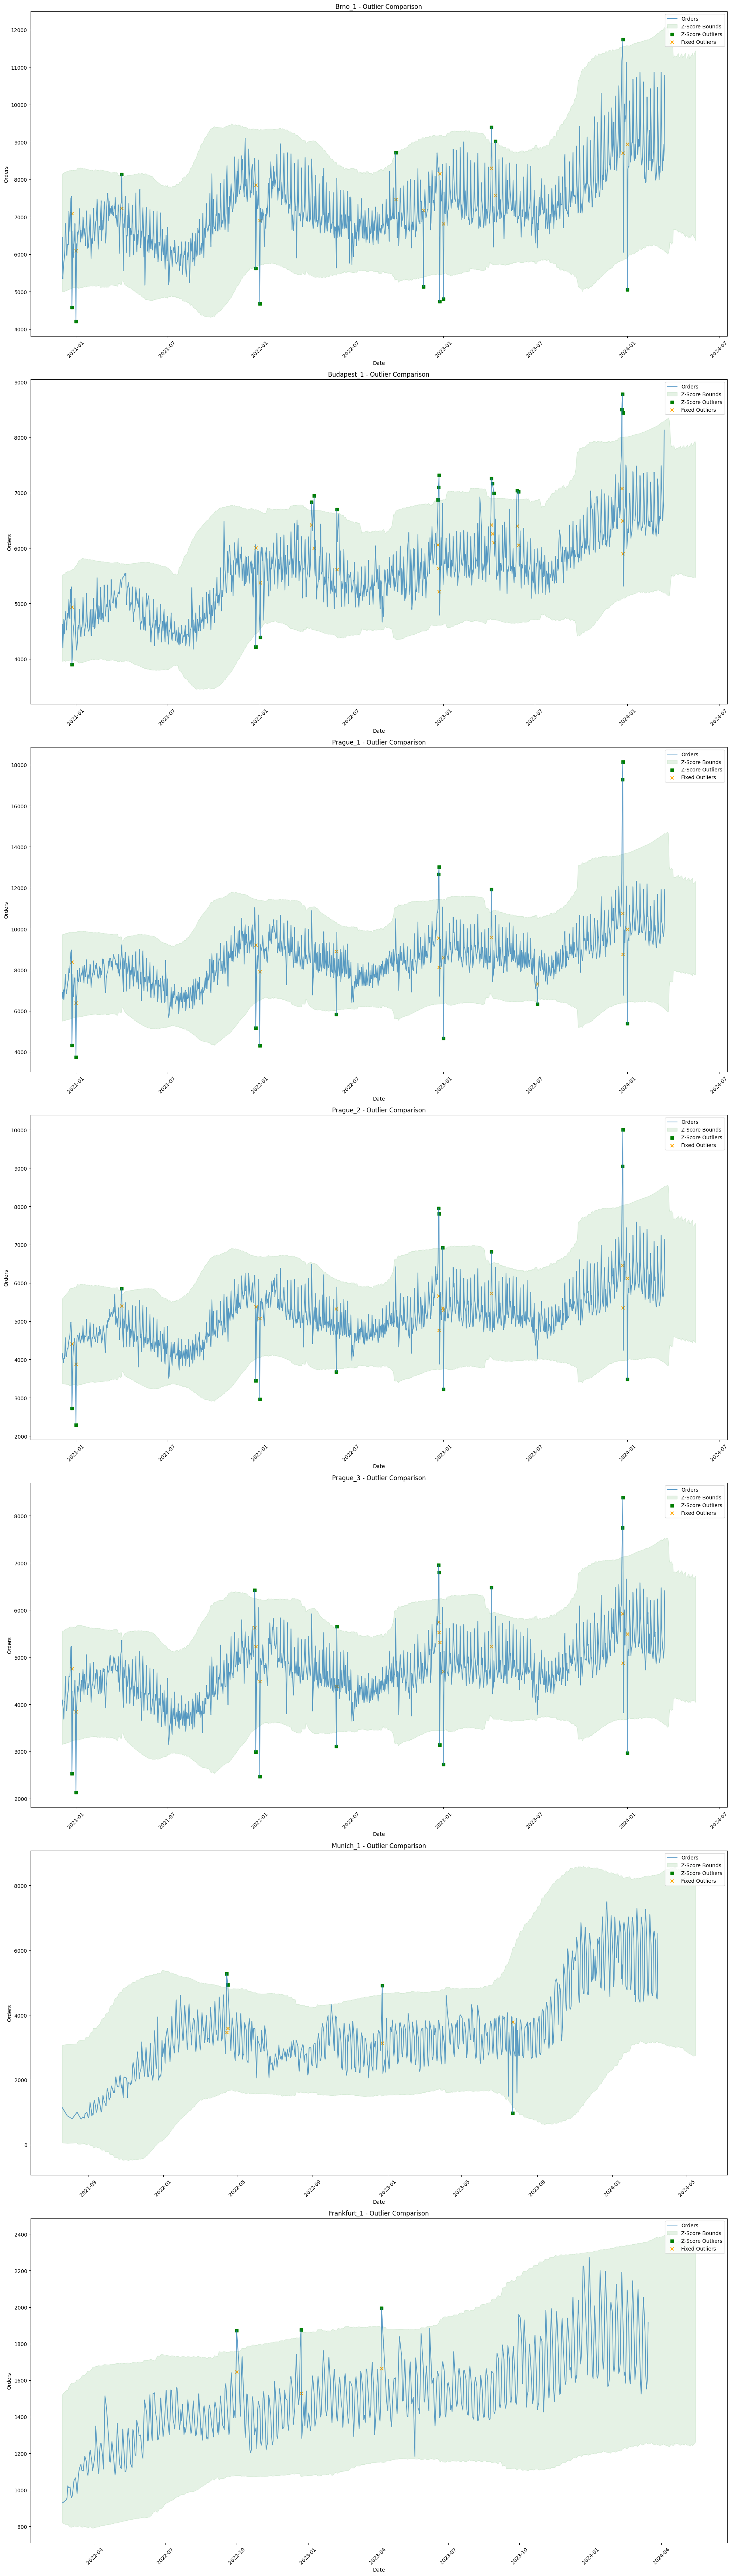


Brno_1:
Z-Score Outliers: 0

Budapest_1:
Z-Score Outliers: 6

Prague_1:
Z-Score Outliers: 6

Prague_2:
Z-Score Outliers: 6

Prague_3:
Z-Score Outliers: 3

Munich_1:
Z-Score Outliers: 1

Frankfurt_1:
Z-Score Outliers: 1


In [23]:
train_df = plot_outlier_comparison(train_df, window=180, z_threshold=2.8)

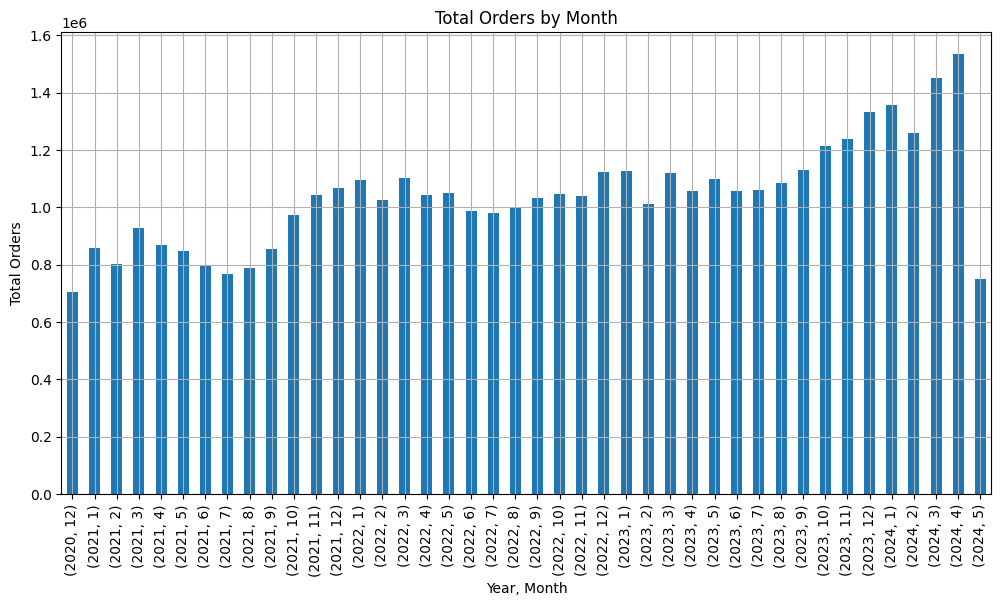

In [24]:
# plot the orders
df_by_month = train_df.groupby(['year', 'month'])['orders'].sum()
df_by_month.plot(kind='bar', figsize=(12, 6))

plt.title('Total Orders by Month')
plt.ylabel('Total Orders')
plt.xlabel('Year, Month')
plt.xticks(np.arange(len(df_by_month)), df_by_month.index, rotation=90)
plt.grid(True)
plt.show()

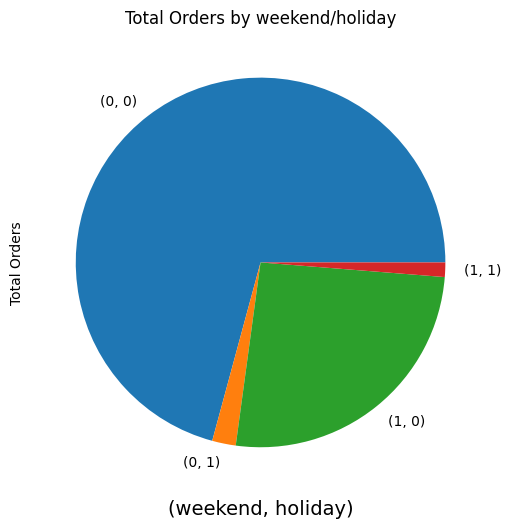

In [25]:
# plot the orders
df_by_month = train_df.groupby(['is_weekend', 'holiday'])['orders'].sum()
df_by_month.plot(kind='pie', figsize=(12, 6))

plt.title('Total Orders by weekend/holiday')
plt.ylabel('Total Orders')
plt.xlabel('(weekend, holiday)', fontdict={'fontsize': 14})
plt.show()

#### Compare feature Colerations

In [26]:
train_df_corr = train_df.drop(columns=['warehouse', "id"]).corr()

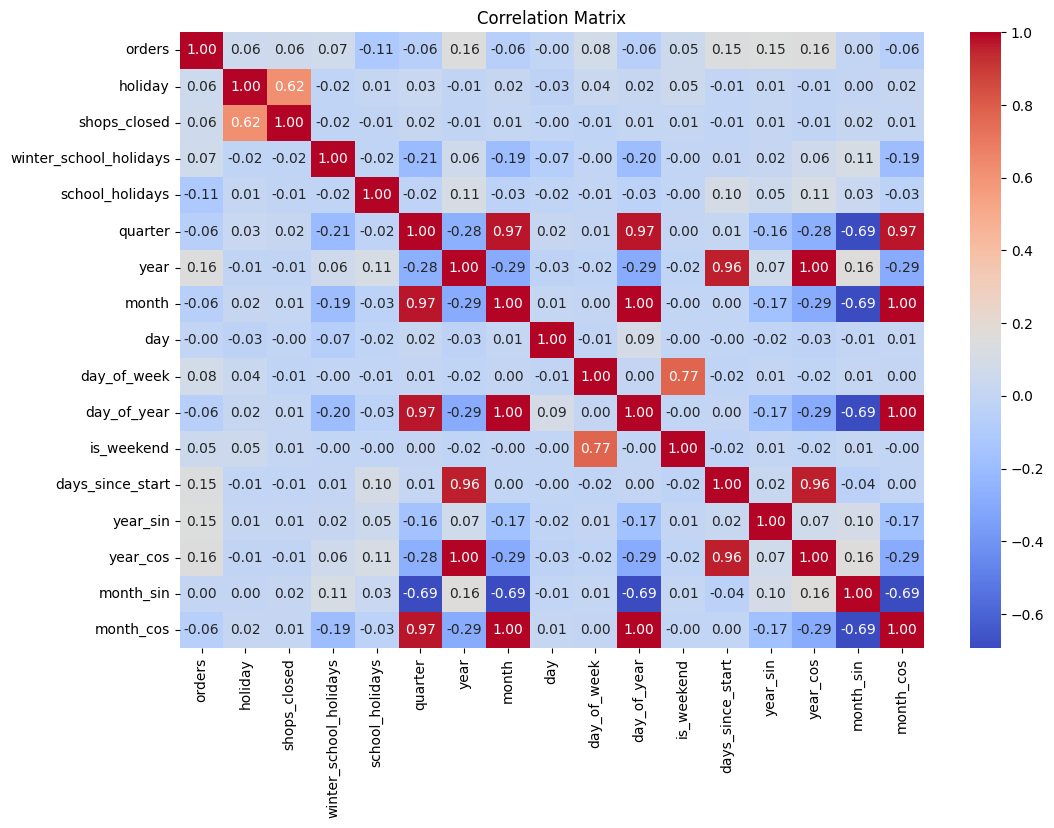

orders                    1.000000
year_cos                  0.157441
year                      0.157441
year_sin                  0.147789
days_since_start          0.145969
day_of_week               0.081944
winter_school_holidays    0.068014
shops_closed              0.062539
holiday                   0.058311
is_weekend                0.048462
month_sin                 0.001280
day                      -0.002302
day_of_year              -0.060822
month                    -0.061573
month_cos                -0.061573
quarter                  -0.062342
school_holidays          -0.113525
Name: orders, dtype: float64


In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(train_df_corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Print the correlation with 'orders'
print(train_df_corr['orders'].sort_values(ascending=False))

### Temporal features

In [29]:
LAG_DAYS = [7, 28, 56, 84, 168, 364]
ROLLING_WINDOW = [28, 168, 364]

In [30]:
def create_lag_features(df, col, lag_days):
    df = df.copy() 
    lag_features = []
    for lag in lag_days:
        feature_name = f'{col}_lag_{lag}'
        df[feature_name] = df.groupby('warehouse')[col].shift(lag)
        lag_features.append(feature_name)
    return df, lag_features

def create_rolling_features(df, col, windows):
    df = df.copy()
    window_features = []
    for window in windows:
        mean_feature = f'{col}_rolling_mean_{window}'
        std_feature = f'{col}_rolling_std_{window}'
        
        df[mean_feature] = df.groupby('warehouse')[col].transform(lambda x: x.rolling(window, min_periods=1).mean())
        df[std_feature] = df.groupby('warehouse')[col].transform(lambda x: x.rolling(window, min_periods=1).std())
        
        window_features.extend([mean_feature, std_feature])
    return df, window_features

In [31]:
train_df, lag_features = create_lag_features(train_df, 'orders', LAG_DAYS)
train_df, window_features = create_rolling_features(train_df, 'orders', ROLLING_WINDOW)

# Im putting my features into categories for better manipulation
numerical_features = ['orders']
numerical_features += lag_features + window_features
categorical_features=categorical_features

print(numerical_features)

train_df.head()

['orders', 'orders_lag_7', 'orders_lag_28', 'orders_lag_56', 'orders_lag_84', 'orders_lag_168', 'orders_lag_364', 'orders_rolling_mean_28', 'orders_rolling_std_28', 'orders_rolling_mean_168', 'orders_rolling_std_168', 'orders_rolling_mean_364', 'orders_rolling_std_364']


warehouse  orders  holiday  shops_closed  winter_school_holidays  \
date                                                                            
2020-12-05      Brno_1  6447.0        0             0                       0   
2020-12-05  Budapest_1  4623.0        0             0                       0   
2020-12-05    Prague_1  6895.0        0             0                       0   
2020-12-05    Prague_2  4154.0        0             0                       0   
2020-12-05    Prague_3  4091.0        0             0                       0   

            school_holidays  quarter  year  month  day  day_of_week  \
date                                                                  
2020-12-05                0        4  2020     12    5            5   
2020-12-05                0        4  2020     12    5            5   
2020-12-05                0        4  2020     12    5            5   
2020-12-05                0        4  2020     12    5            5   
2020-12-05                0        4  2020     12    5            5   

            day_of_year  is_weekend  days_since_start      year_sin  year_cos  \
date                                                                            
2020-12-05          340           1                 0 -1.630940e-09    2020.0   
2020-12-05          340           1                 0 -1.630940e-09    2020.0   
2020-12-05          340           1                 0 -1.630940e-09    2020.0   
2020-12-05          340           1                 0 -1.630940e-09    2020.0   
2020-12-05          340           1                 0 -1.630940e-09    2020.0   

               month_sin  month_cos  orders_lag_7  orders_lag_28  \
date                                                               
2020-12-05 -3.526983e-14       12.0           NaN            NaN   
2020-12-05 -3.526983e-14       12.0           NaN            NaN   
2020-12-05 -3.526983e-14       12.0           NaN            NaN   
2020-12-05 -3.526983e-14       12.0           NaN            NaN   
2020-12-05 -3.526983e-14       12.0           NaN            NaN   

            orders_lag_56  orders_lag_84  orders_lag_168  orders_lag_364  \
date                                                                       
2020-12-05            NaN            NaN             NaN             NaN   
2020-12-05            NaN            NaN             NaN             NaN   
2020-12-05            NaN            NaN             NaN             NaN   
2020-12-05            NaN            NaN             NaN             NaN   
2020-12-05            NaN            NaN             NaN             NaN   

            orders_rolling_mean_28  orders_rolling_std_28  \
date                                                        
2020-12-05                  6447.0                    NaN   
2020-12-05                  4623.0                    NaN   
2020-12-05                  6895.0                    NaN   
2020-12-05                  4154.0                    NaN   
2020-12-05                  4091.0                    NaN   

            orders_rolling_mean_168  orders_rolling_std_168  \
date                                                          
2020-12-05                   6447.0                     NaN   
2020-12-05                   4623.0                     NaN   
2020-12-05                   6895.0                     NaN   
2020-12-05                   4154.0                     NaN   
2020-12-05                   4091.0                     NaN   

            orders_rolling_mean_364  orders_rolling_std_364  
date                                                         
2020-12-05                   6447.0                     NaN  
2020-12-05                   4623.0                     NaN  
2020-12-05                   6895.0                     NaN  
2020-12-05                   4154.0                     NaN  
2020-12-05                   4091.0                     NaN

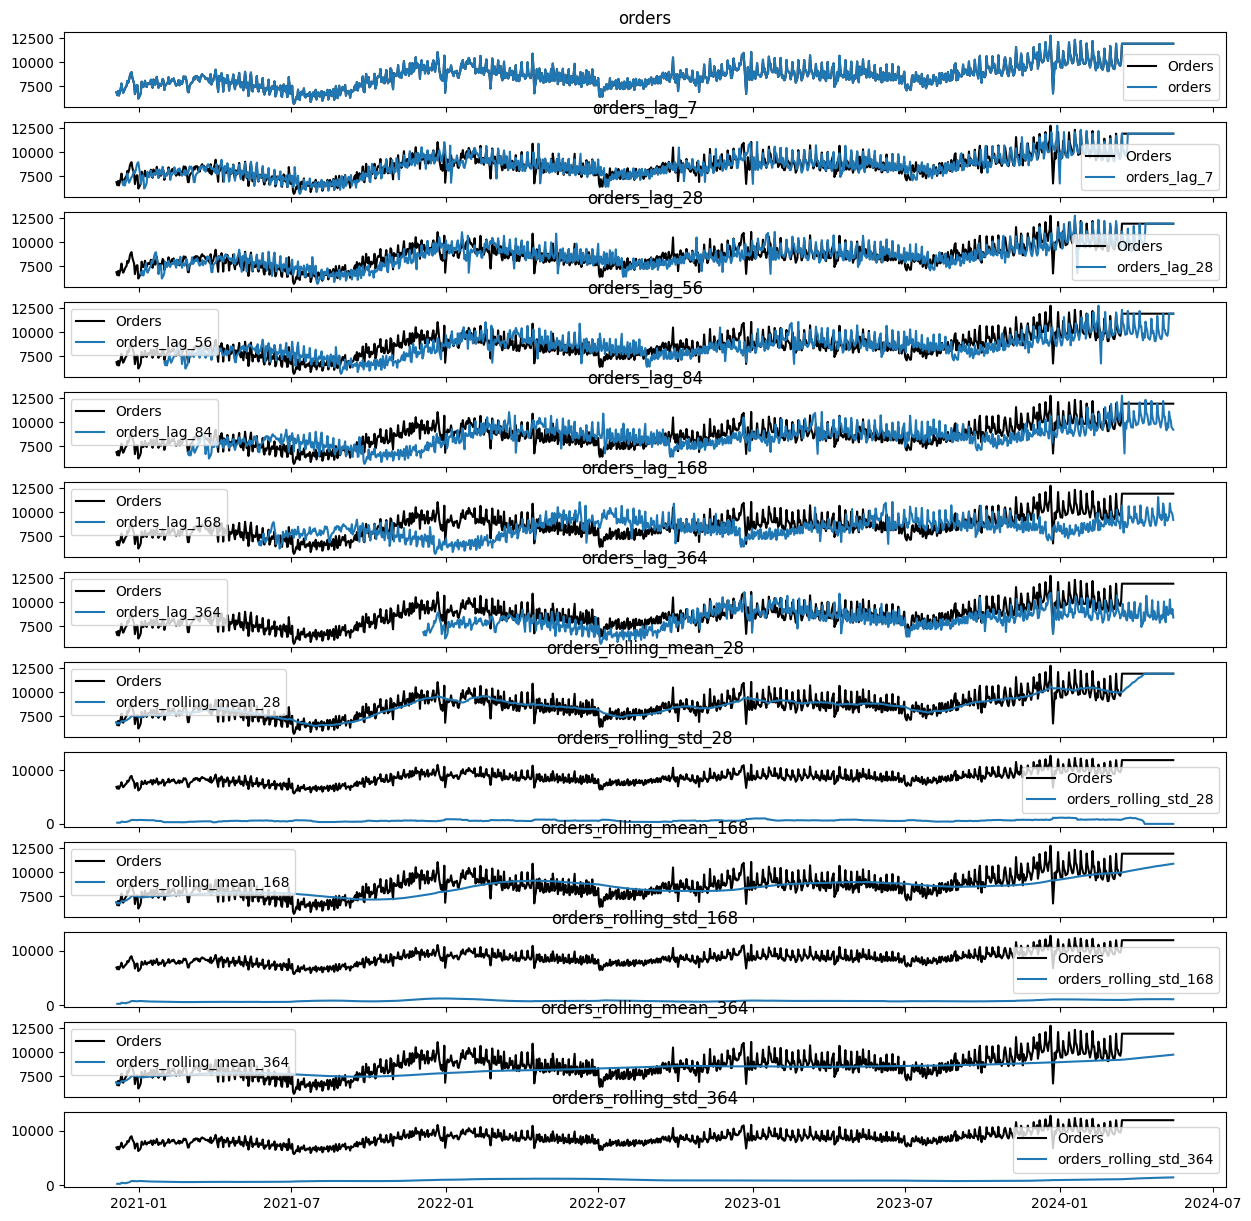

In [32]:
#orders and features above each other (for Prague_1)
fig, ax = plt.subplots(len(numerical_features), 1, figsize=(15, 15), sharex=True)
for i, feature in enumerate(numerical_features):
    ax[i].plot(train_df[train_df.warehouse == 'Prague_1'].index, train_df[train_df.warehouse == 'Prague_1'].orders, label='Orders', color='black')
    ax[i].plot(train_df[train_df.warehouse == 'Prague_1'].index, train_df[train_df.warehouse == 'Prague_1'][feature], label=feature)
    ax[i].set_title(feature)
    ax[i].legend()
plt.show()


In [33]:
# divide dataset back into train and test datasets, for test set to export with new features and train to train on.
test_date_range = (test_df_merged.date.min(), test_df_merged.date.max())
train_date_range = (train_df_merged.date.min(), train_df_merged.date.max())

test_df = train_df.loc[(train_df.index >= test_date_range[0]) & (train_df.index <= test_date_range[1])]
#test_df["date"] = test_df.index
test_df = test_df.drop(columns=['orders'])
train_df = train_df.loc[(train_df.index >= train_date_range[0]) & (train_df.index <= train_date_range[1])]

In [34]:
train_df.tail()

warehouse   orders  holiday  shops_closed  \
date                                                      
2024-03-15  Frankfurt_1   1916.0        0             0   
2024-03-15     Munich_1   6512.0        0             0   
2024-03-15     Prague_1  11917.0        0             0   
2024-03-15     Prague_2   7140.0        0             0   
2024-03-15     Prague_3   6408.0        0             0   

            winter_school_holidays  school_holidays  quarter  year  month  \
date                                                                        
2024-03-15                       0                0        1  2024      3   
2024-03-15                       0                0        1  2024      3   
2024-03-15                       0                0        1  2024      3   
2024-03-15                       0                0        1  2024      3   
2024-03-15                       0                0        1  2024      3   

            day  day_of_week  day_of_year  is_weekend  days_since_start  \
date                                                                      
2024-03-15   15            4           75           0              1196   
2024-03-15   15            4           75           0              1196   
2024-03-15   15            4           75           0              1196   
2024-03-15   15            4           75           0              1196   
2024-03-15   15            4           75           0              1196   

                year_sin  year_cos     month_sin  month_cos  orders_lag_7  \
date                                                                        
2024-03-15  3.208798e-11    2024.0 -2.204364e-15        3.0        1610.0   
2024-03-15  3.208798e-11    2024.0 -2.204364e-15        3.0        4694.0   
2024-03-15  3.208798e-11    2024.0 -2.204364e-15        3.0       11917.0   
2024-03-15  3.208798e-11    2024.0 -2.204364e-15        3.0        7253.0   
2024-03-15  3.208798e-11    2024.0 -2.204364e-15        3.0        6473.0   

            orders_lag_28  orders_lag_56  orders_lag_84  orders_lag_168  \
date                                                                      
2024-03-15         1844.0         1611.0         1657.0          1639.0   
2024-03-15         6128.0         6454.0         5824.0          3501.0   
2024-03-15        11095.0        12319.0        12744.0         10668.0   
2024-03-15         6773.0         7590.0         7564.0          6605.0   
2024-03-15         6203.0         6450.0         6974.0          6086.0   

            orders_lag_364  orders_rolling_mean_28  orders_rolling_std_28  \
date                                                                        
2024-03-15          1324.0             1773.750000             193.275015   
2024-03-15          2331.0             5546.464286            1036.562463   
2024-03-15          8791.0            10030.214286             809.959960   
2024-03-15          5153.0             5990.928571             549.579498   
2024-03-15          4538.0             5366.750000             466.662351   

            orders_rolling_mean_168  orders_rolling_std_168  \
date                                                          
2024-03-15              1734.309524              199.819168   
2024-03-15              5184.815476             1184.570200   
2024-03-15              9972.467262              935.747306   
2024-03-15              5986.312500              586.376313   
2024-03-15              5391.422619              514.338425   

            orders_rolling_mean_364  orders_rolling_std_364  
date                                                         
2024-03-15              1619.663462              193.894642  
2024-03-15              4142.582418             1316.726863  
2024-03-15              9222.311813             1071.390483  
2024-03-15              5554.064560              643.079623  
2024-03-15              5054.175824              542.489822

In [35]:
print(f"Train data: {train_df.shape}")
print(f"Test data: {test_df.shape}")

Train data: (7340, 30)
Test data: (397, 29)


In [36]:
# Save test datas for future inference
test_df.to_csv('data/test_proc_mt.csv')

In [37]:
train_df = train_df.drop(columns=['id'])

KeyError: "['id'] not found in axis"

### OH encoding of categorical features

In [37]:
from sklearn.preprocessing import OneHotEncoder
import joblib

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

encoded_features = encoder.fit_transform(train_df[categorical_features])

#Get the encoded feature names
encoded_feature_names = encoder.get_feature_names_out(categorical_features)

encoded_df = pd.DataFrame(encoded_features, columns=encoded_feature_names)

encoded_df.index = train_df.index

train_df = pd.concat([train_df, encoded_df], axis=1)

joblib.dump(encoder, 'scaler_onehot_categorical.joblib')

['scaler_onehot_categorical_mt.joblib']

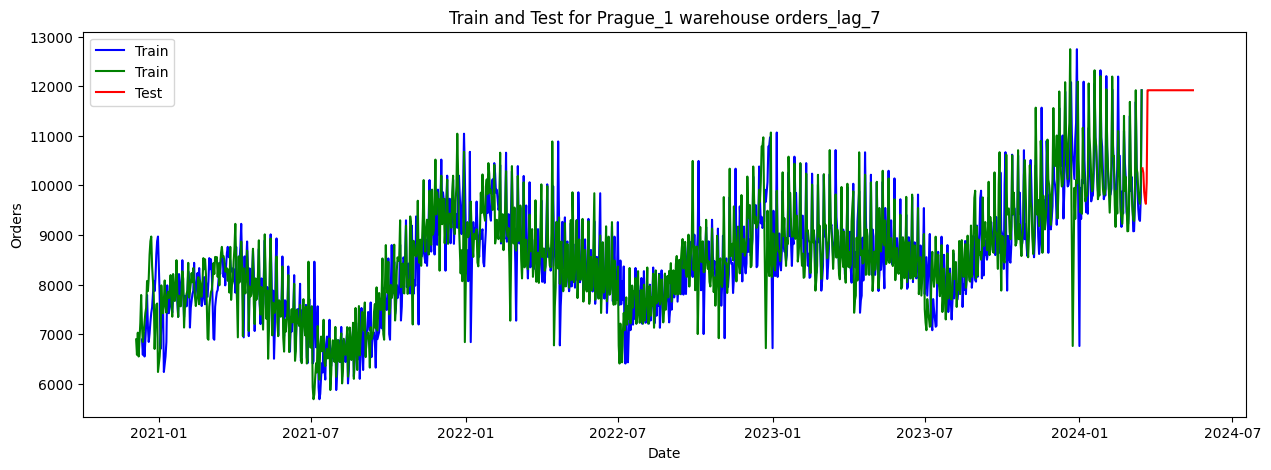

In [38]:
# plot the train and test datasets and visualise them in diferent colors for only column of prague_1 warehouse
feature = f'orders_lag_{LAG_DAYS[0]}'

plt.figure(figsize=(15, 5)) 
datax = train_df[train_df['warehouse'] == 'Prague_1']
datax_test = test_df[test_df['warehouse'] == 'Prague_1']
plt.plot(datax.index, datax[feature], label='Train', color='blue')
plt.plot(datax.index, datax['orders'], label='Train', color='green')
plt.plot(datax_test.index, datax_test[feature], label='Test', color='red')


plt.title(f'Train and Test for Prague_1 warehouse {feature}')

plt.xlabel('Date')
plt.ylabel('Orders')
plt.legend()
plt.show()

In [39]:
print(f"Train data: {train_df.shape}")
print(f"Test data: {test_df.shape}")

Train data: (7340, 30)
Test data: (397, 29)


In [40]:
print(train_df.isna().sum())  # Check for Nas

warehouse                     0
orders                        0
holiday                       0
shops_closed                  0
winter_school_holidays        0
school_holidays               0
quarter                       0
year                          0
month                         0
day                           0
day_of_week                   0
day_of_year                   0
is_weekend                    0
days_since_start              0
year_sin                      0
year_cos                      0
month_sin                     0
month_cos                     0
orders_lag_7                 49
orders_lag_28               196
orders_lag_56               392
orders_lag_84               588
orders_lag_168             1176
orders_lag_364             2548
orders_rolling_mean_28        0
orders_rolling_std_28         7
orders_rolling_mean_168       0
orders_rolling_std_168        7
orders_rolling_mean_364       0
orders_rolling_std_364        7
dtype: int64


In [41]:
"""lag_roll features
"""
LAG_ROLL_FEATURES = []
for feature in numerical_features:
    if 'lag' in feature or 'rolling' in feature:
        LAG_ROLL_FEATURES.append(feature)
print(LAG_ROLL_FEATURES)                                             

['orders_lag_7', 'orders_lag_28', 'orders_lag_56', 'orders_lag_84', 'orders_lag_168', 'orders_lag_364', 'orders_rolling_mean_28', 'orders_rolling_std_28', 'orders_rolling_mean_168', 'orders_rolling_std_168', 'orders_rolling_mean_364', 'orders_rolling_std_364']


In [42]:
# Save all scaler features into singe json scaler config file:
scaler_config = {
    'bin_features': binary_features,
    'cat_features': categorical_features
}

# Save the scaler config
joblib.dump(scaler_config, 'scaler_config.joblib')

['scaler_config.joblib']

In [43]:
print("Start Date:", train_df.index.min())
print("End Date:", train_df.index.max())        

Start Date: 2020-12-05 00:00:00
End Date: 2024-03-15 00:00:00


In [44]:
# check non-continuos date timeline
train_df.index.to_series().diff().value_counts()

date
0 days    6147
1 days    1188
2 days       4
Name: count, dtype: int64

In [45]:
#Standard Scaler:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

def scale_data(X_train, y_train):
    # Initialize the scaler
    x_scaler = StandardScaler()
    y_scaler = StandardScaler()

    # dump X_train columns for future inference to the scaler config:
    scaler_config['scaler_features'] = list(X_train.columns)

    # Fit the scaler on the numeriacal columns
    X_train_scaled = pd.DataFrame(x_scaler.fit_transform(X_train), columns=X_train.columns)
    y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))

    return X_train_scaled, y_train_scaled, x_scaler, y_scaler

In [46]:
train_df.head()

warehouse  orders  holiday  shops_closed  winter_school_holidays  \
date                                                                            
2020-12-05      Brno_1  6447.0        0             0                       0   
2020-12-05  Budapest_1  4623.0        0             0                       0   
2020-12-05    Prague_1  6895.0        0             0                       0   
2020-12-05    Prague_2  4154.0        0             0                       0   
2020-12-05    Prague_3  4091.0        0             0                       0   

            school_holidays  quarter  year  month  day  day_of_week  \
date                                                                  
2020-12-05                0        4  2020     12    5            5   
2020-12-05                0        4  2020     12    5            5   
2020-12-05                0        4  2020     12    5            5   
2020-12-05                0        4  2020     12    5            5   
2020-12-05                0        4  2020     12    5            5   

            day_of_year  is_weekend  days_since_start      year_sin  year_cos  \
date                                                                            
2020-12-05          340           1                 0 -1.630940e-09    2020.0   
2020-12-05          340           1                 0 -1.630940e-09    2020.0   
2020-12-05          340           1                 0 -1.630940e-09    2020.0   
2020-12-05          340           1                 0 -1.630940e-09    2020.0   
2020-12-05          340           1                 0 -1.630940e-09    2020.0   

               month_sin  month_cos  orders_lag_7  orders_lag_28  \
date                                                               
2020-12-05 -3.526983e-14       12.0           NaN            NaN   
2020-12-05 -3.526983e-14       12.0           NaN            NaN   
2020-12-05 -3.526983e-14       12.0           NaN            NaN   
2020-12-05 -3.526983e-14       12.0           NaN            NaN   
2020-12-05 -3.526983e-14       12.0           NaN            NaN   

            orders_lag_56  orders_lag_84  orders_lag_168  orders_lag_364  \
date                                                                       
2020-12-05            NaN            NaN             NaN             NaN   
2020-12-05            NaN            NaN             NaN             NaN   
2020-12-05            NaN            NaN             NaN             NaN   
2020-12-05            NaN            NaN             NaN             NaN   
2020-12-05            NaN            NaN             NaN             NaN   

            orders_rolling_mean_28  orders_rolling_std_28  \
date                                                        
2020-12-05                  6447.0                    NaN   
2020-12-05                  4623.0                    NaN   
2020-12-05                  6895.0                    NaN   
2020-12-05                  4154.0                    NaN   
2020-12-05                  4091.0                    NaN   

            orders_rolling_mean_168  orders_rolling_std_168  \
date                                                          
2020-12-05                   6447.0                     NaN   
2020-12-05                   4623.0                     NaN   
2020-12-05                   6895.0                     NaN   
2020-12-05                   4154.0                     NaN   
2020-12-05                   4091.0                     NaN   

            orders_rolling_mean_364  orders_rolling_std_364  
date                                                         
2020-12-05                   6447.0                     NaN  
2020-12-05                   4623.0                     NaN  
2020-12-05                   6895.0                     NaN  
2020-12-05                   4154.0                     NaN  
2020-12-05                   4091.0                     NaN

## Training Loop

In [47]:
train_df = train_df.fillna(0)

In [48]:
train_df.head()

warehouse  orders  holiday  shops_closed  winter_school_holidays  \
date                                                                            
2020-12-05      Brno_1  6447.0        0             0                       0   
2020-12-05  Budapest_1  4623.0        0             0                       0   
2020-12-05    Prague_1  6895.0        0             0                       0   
2020-12-05    Prague_2  4154.0        0             0                       0   
2020-12-05    Prague_3  4091.0        0             0                       0   

            school_holidays  quarter  year  month  day  day_of_week  \
date                                                                  
2020-12-05                0        4  2020     12    5            5   
2020-12-05                0        4  2020     12    5            5   
2020-12-05                0        4  2020     12    5            5   
2020-12-05                0        4  2020     12    5            5   
2020-12-05                0        4  2020     12    5            5   

            day_of_year  is_weekend  days_since_start      year_sin  year_cos  \
date                                                                            
2020-12-05          340           1                 0 -1.630940e-09    2020.0   
2020-12-05          340           1                 0 -1.630940e-09    2020.0   
2020-12-05          340           1                 0 -1.630940e-09    2020.0   
2020-12-05          340           1                 0 -1.630940e-09    2020.0   
2020-12-05          340           1                 0 -1.630940e-09    2020.0   

               month_sin  month_cos  orders_lag_7  orders_lag_28  \
date                                                               
2020-12-05 -3.526983e-14       12.0           0.0            0.0   
2020-12-05 -3.526983e-14       12.0           0.0            0.0   
2020-12-05 -3.526983e-14       12.0           0.0            0.0   
2020-12-05 -3.526983e-14       12.0           0.0            0.0   
2020-12-05 -3.526983e-14       12.0           0.0            0.0   

            orders_lag_56  orders_lag_84  orders_lag_168  orders_lag_364  \
date                                                                       
2020-12-05            0.0            0.0             0.0             0.0   
2020-12-05            0.0            0.0             0.0             0.0   
2020-12-05            0.0            0.0             0.0             0.0   
2020-12-05            0.0            0.0             0.0             0.0   
2020-12-05            0.0            0.0             0.0             0.0   

            orders_rolling_mean_28  orders_rolling_std_28  \
date                                                        
2020-12-05                  6447.0                    0.0   
2020-12-05                  4623.0                    0.0   
2020-12-05                  6895.0                    0.0   
2020-12-05                  4154.0                    0.0   
2020-12-05                  4091.0                    0.0   

            orders_rolling_mean_168  orders_rolling_std_168  \
date                                                          
2020-12-05                   6447.0                     0.0   
2020-12-05                   4623.0                     0.0   
2020-12-05                   6895.0                     0.0   
2020-12-05                   4154.0                     0.0   
2020-12-05                   4091.0                     0.0   

            orders_rolling_mean_364  orders_rolling_std_364  
date                                                         
2020-12-05                   6447.0                     0.0  
2020-12-05                   4623.0                     0.0  
2020-12-05                   6895.0                     0.0  
2020-12-05                   4154.0                     0.0  
2020-12-05                   4091.0                     0.0

In [49]:
def preprocess_data(df, cat_features, inference=False, scaler_features):
    
    # create lag and rolling features:
    df, lag_features = create_lag_features(df, 'orders', LAG_DAYS)
    df, window_features = create_rolling_features(df, 'orders', ROLLING_WINDOW)
    
    # fill nan values with mean:
    #df = df.fillna(df.mean())
    
    # One hot encoder:
    from sklearn.preprocessing import OneHotEncoder
    import joblib
    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

    encoded_features = encoder.fit_transform(df[cat_features])

    #Get the encoded feature names
    encoded_feature_names = encoder.get_feature_names_out(cat_features)

    encoded_df = pd.DataFrame(encoded_features, columns=encoded_feature_names)

    encoded_df.index = train_df.index

    df = pd.concat([train_df, encoded_df], axis=1)

    joblib.dump(encoder, 'onehot_scaler.joblib')
    
    
    # Drop the orders column
    X_train = df.drop(columns=['orders'])
    y_train = df['orders']
    # Drop the warehouse column
    #X_train = X_train.drop(columns=['warehouse'])
    # Drop the categorical features (one-hot encoded)
    #X_train= X_train.drop(columns=categorical_features)
    # Drop the binary features and store them separately (to be concatenated later)
    #X_binary = X_train[binary_features]
    #X_train = X_train.drop(columns=binary_features)
    
    # Initialize the scaler
    x_scaler = StandardScaler()
    y_scaler = StandardScaler()

    # dump X_train columns for future inference to the scaler config:
    #scaler_config['scaler_features'] = list(X_train.columns)

    # Fit the scaler on the numeriacal columns
    X_train_scaled = pd.DataFrame(x_scaler.fit_transform(X_train), columns=scaler_features)
    y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
    
    joblib.dump(x_scaler, f'x_scaler.joblib')
    joblib.dump(y_scaler, f'y_scaler.joblib')
    
    # Concatenate the binary features back to the scaled features
    #X_binary = X_binary.reset_index(drop=True)
    #X_train_scaled = pd.concat([X_train_scaled, X_binary], axis=1)
    
    
    return X_train_scaled, y_train_scaled

SyntaxError: non-default argument follows default argument (1302559316.py, line 1)

In [48]:
def create_sequences(X_train_scaled, y_train_scaled, time_steps):
    # Create sequences for each warehouse
    
    sequences = []
    targets = []

    if len(X_train_scaled) > time_steps:
        generator = TimeseriesGenerator(X_train_scaled.values, 
                                        y_train_scaled, 
                                        length=time_steps, 
                                        batch_size=1)
        
        for i in range(len(generator)):
            x, y = generator[i]
            sequences.append(x)
            targets.append(y)

    X = np.array(sequences)
    y = np.array(targets)

    X = np.squeeze(X, axis=1)
    y = np.squeeze(y, axis=1)
    
    print(f"final shape: {X.shape, y.shape}")
    
    return X, y

In [49]:
def create_model(input_shape, lr=1e-3):

    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Bidirectional(LSTM(units=64, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=32, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=16, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Dense(units=1))

    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=lr))

    return model

In [50]:
def plot_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Training and Validation Loss of {warehouse}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [ ]:
X_train_df, y_train_df = preprocess_data(warehouse_data, inference=False)
print(X_train_df.head())

Training model for warehouse: Brno_1
      month       day  day_of_year  days_since_start  year_sin  year_cos  \
0  1.577677 -1.211889     1.483102         -1.732070  -0.30871 -2.145151   
1  1.577677 -1.097922     1.492208         -1.729174  -0.30871 -2.145151   
2  1.577677 -0.983955     1.501315         -1.726278  -0.30871 -2.145151   
3  1.577677 -0.869988     1.510421         -1.723382  -0.30871 -2.145151   
4  1.577677 -0.756021     1.519528         -1.720486  -0.30871 -2.145151   

   month_sin  month_cos  orders_lag_7  orders_lag_28  orders_lag_56  \
0  -0.595108   1.577677     -6.732091       -5.01348      -3.948298   
1  -0.595108   1.577677     -6.732091       -5.01348      -3.948298   
2  -0.595108   1.577677     -6.732091       -5.01348      -3.948298   
3  -0.595108   1.577677     -6.732091       -5.01348      -3.948298   
4  -0.595108   1.577677     -6.732091       -5.01348      -3.948298   

   orders_lag_84  orders_lag_168  orders_lag_364  orders_rolling_mean_28  \
0  

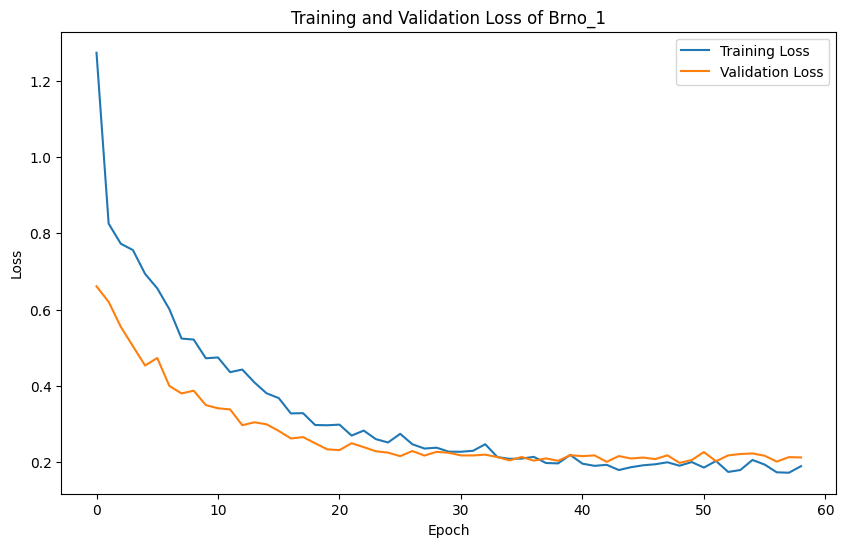

Training model for warehouse: Budapest_1
      month       day  day_of_year  days_since_start  year_sin  year_cos  \
0  1.572395 -1.229544     1.479045         -1.734344 -0.309239  -2.14543   
1  1.572395 -1.114895     1.488152         -1.731448 -0.309239  -2.14543   
2  1.572395 -1.000246     1.497258         -1.728552 -0.309239  -2.14543   
3  1.572395 -0.885598     1.506365         -1.725657 -0.309239  -2.14543   
4  1.572395 -0.770949     1.515471         -1.722761 -0.309239  -2.14543   

   month_sin  month_cos  orders_lag_7  orders_lag_28  orders_lag_56  \
0  -0.594074   1.572395     -7.108446      -5.105368      -3.950705   
1  -0.594074   1.572395     -7.108446      -5.105368      -3.950705   
2  -0.594074   1.572395     -7.108446      -5.105368      -3.950705   
3  -0.594074   1.572395     -7.108446      -5.105368      -3.950705   
4  -0.594074   1.572395     -7.108446      -5.105368      -3.950705   

   orders_lag_84  orders_lag_168  orders_lag_364  orders_rolling_mean_28  \

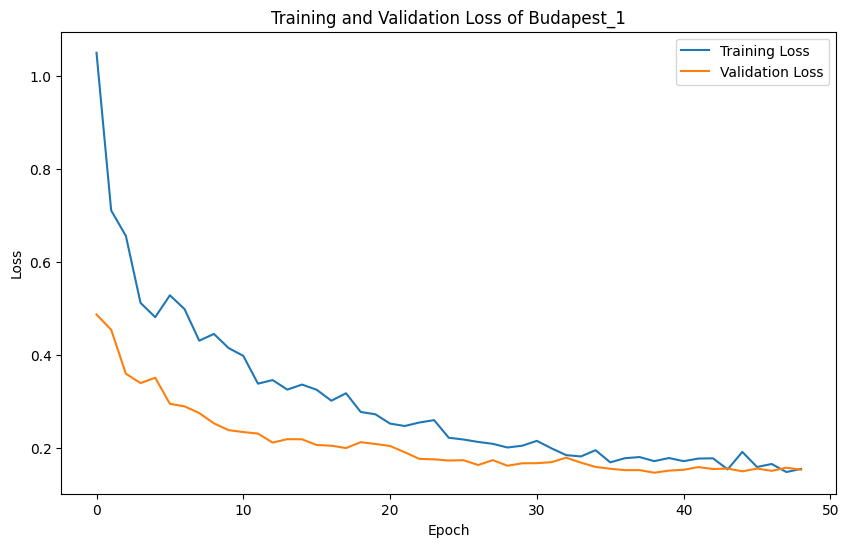

Training model for warehouse: Prague_1
      month       day  day_of_year  days_since_start  year_sin  year_cos  \
0  1.577677 -1.211889     1.483102         -1.732070  -0.30871 -2.145151   
1  1.577677 -1.097922     1.492208         -1.729174  -0.30871 -2.145151   
2  1.577677 -0.983955     1.501315         -1.726278  -0.30871 -2.145151   
3  1.577677 -0.869988     1.510421         -1.723382  -0.30871 -2.145151   
4  1.577677 -0.756021     1.519528         -1.720486  -0.30871 -2.145151   

   month_sin  month_cos  orders_lag_7  orders_lag_28  orders_lag_56  \
0  -0.595108   1.577677     -6.653336      -4.954561      -3.906914   
1  -0.595108   1.577677     -6.653336      -4.954561      -3.906914   
2  -0.595108   1.577677     -6.653336      -4.954561      -3.906914   
3  -0.595108   1.577677     -6.653336      -4.954561      -3.906914   
4  -0.595108   1.577677     -6.653336      -4.954561      -3.906914   

   orders_lag_84  orders_lag_168  orders_lag_364  orders_rolling_mean_28  \
0

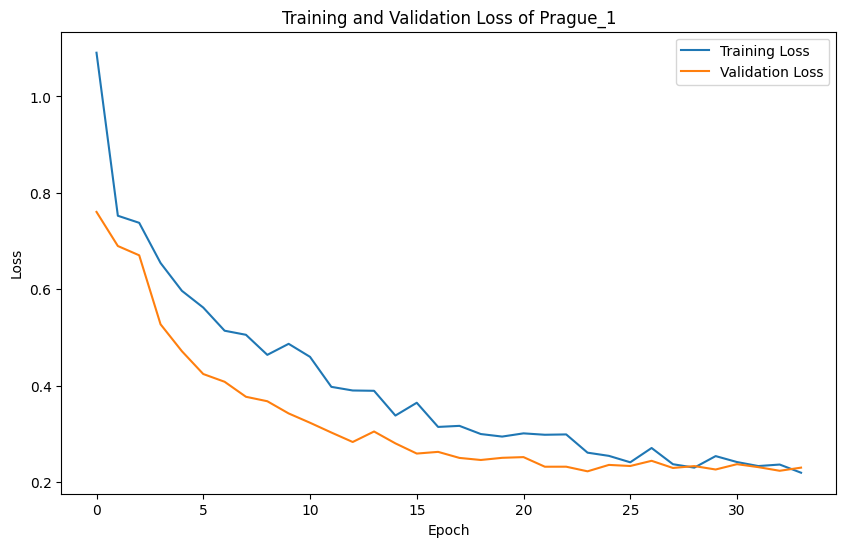

Training model for warehouse: Prague_2
      month       day  day_of_year  days_since_start  year_sin  year_cos  \
0  1.577677 -1.211889     1.483102         -1.732070  -0.30871 -2.145151   
1  1.577677 -1.097922     1.492208         -1.729174  -0.30871 -2.145151   
2  1.577677 -0.983955     1.501315         -1.726278  -0.30871 -2.145151   
3  1.577677 -0.869988     1.510421         -1.723382  -0.30871 -2.145151   
4  1.577677 -0.756021     1.519528         -1.720486  -0.30871 -2.145151   

   month_sin  month_cos  orders_lag_7  orders_lag_28  orders_lag_56  \
0  -0.595108   1.577677     -6.839306      -5.033776      -3.948105   
1  -0.595108   1.577677     -6.839306      -5.033776      -3.948105   
2  -0.595108   1.577677     -6.839306      -5.033776      -3.948105   
3  -0.595108   1.577677     -6.839306      -5.033776      -3.948105   
4  -0.595108   1.577677     -6.839306      -5.033776      -3.948105   

   orders_lag_84  orders_lag_168  orders_lag_364  orders_rolling_mean_28  \
0

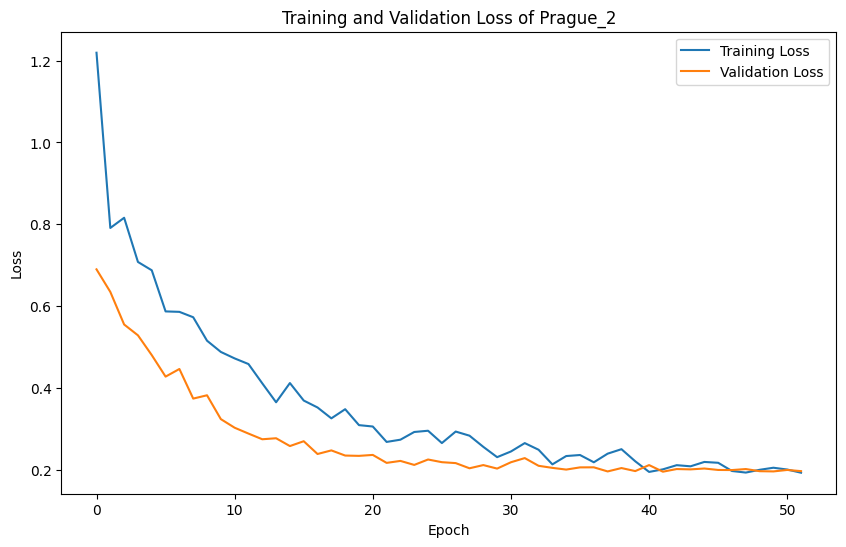

Training model for warehouse: Prague_3
      month       day  day_of_year  days_since_start  year_sin  year_cos  \
0  1.577677 -1.211889     1.483102         -1.732070  -0.30871 -2.145151   
1  1.577677 -1.097922     1.492208         -1.729174  -0.30871 -2.145151   
2  1.577677 -0.983955     1.501315         -1.726278  -0.30871 -2.145151   
3  1.577677 -0.869988     1.510421         -1.723382  -0.30871 -2.145151   
4  1.577677 -0.756021     1.519528         -1.720486  -0.30871 -2.145151   

   month_sin  month_cos  orders_lag_7  orders_lag_28  orders_lag_56  \
0  -0.595108   1.577677     -7.054334      -5.110989      -3.976225   
1  -0.595108   1.577677     -7.054334      -5.110989      -3.976225   
2  -0.595108   1.577677     -7.054334      -5.110989      -3.976225   
3  -0.595108   1.577677     -7.054334      -5.110989      -3.976225   
4  -0.595108   1.577677     -7.054334      -5.110989      -3.976225   

   orders_lag_84  orders_lag_168  orders_lag_364  orders_rolling_mean_28  \
0

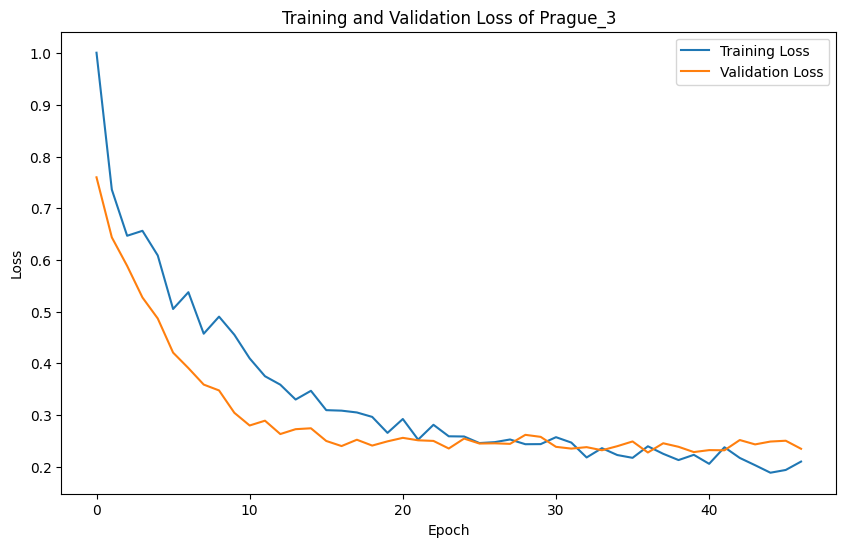

Training model for warehouse: Munich_1
      month       day  day_of_year  days_since_start  year_sin  year_cos  \
0  0.083277  0.588953     0.122178         -1.818241  1.321338 -1.672567   
1  0.083277  1.503095     0.194412         -1.788946  1.321338 -1.672567   
2  0.359112 -1.125065     0.266647         -1.759652  1.321338 -1.672567   
3  0.359112 -0.325190     0.329852         -1.734019  1.321338 -1.672567   
4  0.359112 -0.210922     0.338881         -1.730357  1.321338 -1.672567   

   month_sin  month_cos  orders_lag_7  orders_lag_28  orders_lag_56  \
0   0.322976   0.083277     -2.562837      -2.365697      -2.193495   
1   0.322976   0.083277     -2.562837      -2.365697      -2.193495   
2   0.200314   0.359112     -2.562837      -2.365697      -2.193495   
3   0.200314   0.359112     -2.562837      -2.365697      -2.193495   
4   0.200314   0.359112     -2.562837      -2.365697      -2.193495   

   orders_lag_84  orders_lag_168  orders_lag_364  orders_rolling_mean_28  \
0

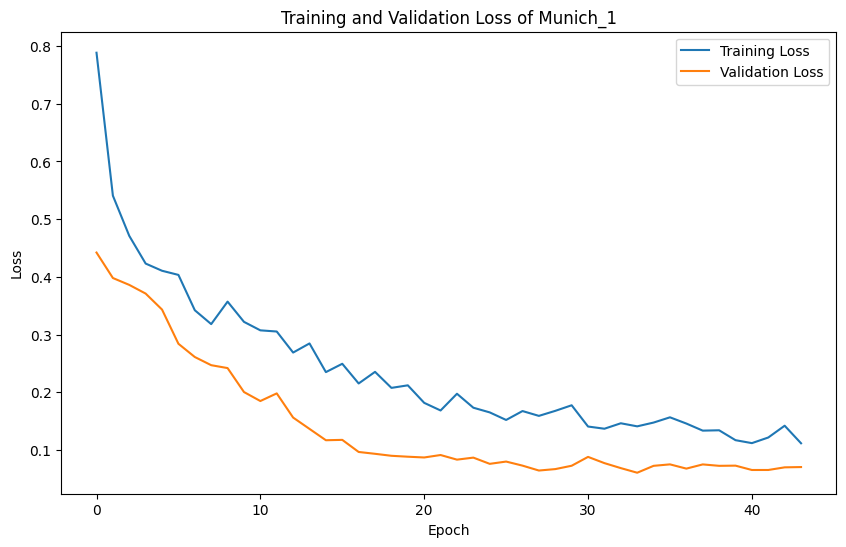

Training model for warehouse: Frankfurt_1
      month       day  day_of_year  days_since_start  year_sin  year_cos  \
0 -1.265564  0.261037    -1.226255         -1.742215 -1.058147 -1.058326   
1 -1.265564  0.374980    -1.216808         -1.737629 -1.058147 -1.058326   
2 -1.265564  0.830753    -1.179023         -1.719286 -1.058147 -1.058326   
3 -1.265564  0.944696    -1.169577         -1.714700 -1.058147 -1.058326   
4 -1.265564  1.058639    -1.160130         -1.710114 -1.058147 -1.058326   

   month_sin  month_cos  orders_lag_7  orders_lag_28  orders_lag_56  \
0   0.648776  -1.265564     -5.338042       -3.76459      -2.883039   
1   0.648776  -1.265564     -5.338042       -3.76459      -2.883039   
2   0.648776  -1.265564     -5.338042       -3.76459      -2.883039   
3   0.648776  -1.265564     -5.338042       -3.76459      -2.883039   
4   0.648776  -1.265564     -5.338042       -3.76459      -2.883039   

   orders_lag_84  orders_lag_168  orders_lag_364  orders_rolling_mean_28  

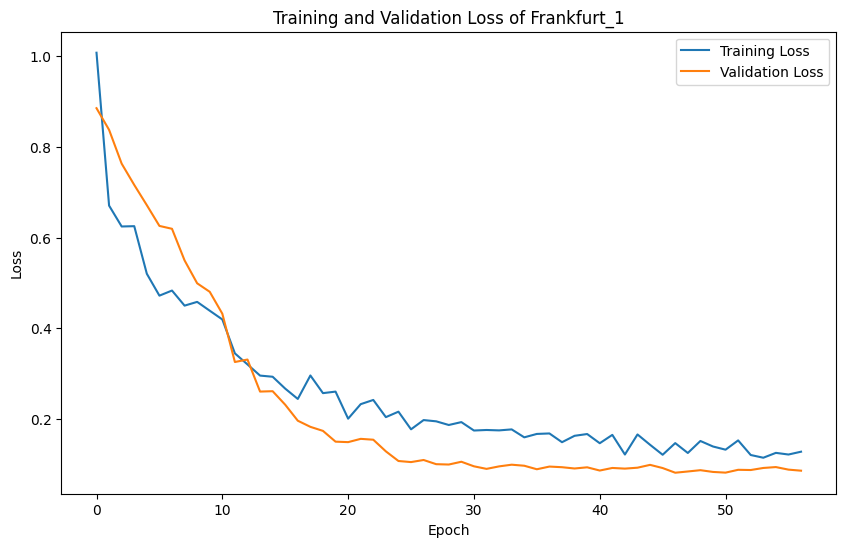

['scaler_config.joblib']

In [53]:
# Train models for each warehouse
warehouses = train_df['warehouse'].unique()

for warehouse in warehouses:
    print(f"Training model for warehouse: {warehouse}")
    
    #warehouse_data = train_df[train_df['warehouse'] == warehouse]
    
    #X_train_df, y_train_df, x_scaler, y_scaler = preprocess_data(warehouse_data, warehouse)
    #print(X_train_df.head())
    #scaler_config['model_features'] = list(X_train_df.columns)
    
    X_train_wh = X_train_df[X_train_df['warehouse'] == warehouse]
    y_train_wh = y_train_df[y_train_df['warehouse'] == warehouse]
        
    # Create sequences
    X_seq, y_seq = create_sequences(X_train_wh, y_train_wh, time_steps=28)
    
    # Split data
    X_train, X_val, y_train, y_val = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=True, random_state=42)
    
    # Create and train model
    model = create_model(input_shape=(X_train.shape[1], X_train.shape[2]))
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ModelCheckpoint(f'model_{warehouse}.keras', save_best_only=True, monitor='val_loss', mode='min', verbose=1)
    ]
    
    history = model.fit(
        X_train, y_train, 
        epochs=200, 
        batch_size=32, 
        validation_data=(X_val, y_val), 
        callbacks=callbacks,
        verbose=1
    )
    
    
    plot_loss(history)
    
# Save the scaler config
joblib.dump(scaler_config, 'scaler_config.joblib')


## Inference

#### MAPE

Predicting for warehouse: Brno_1
final shape: ((1165, 28, 41), (1165, 1))
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step


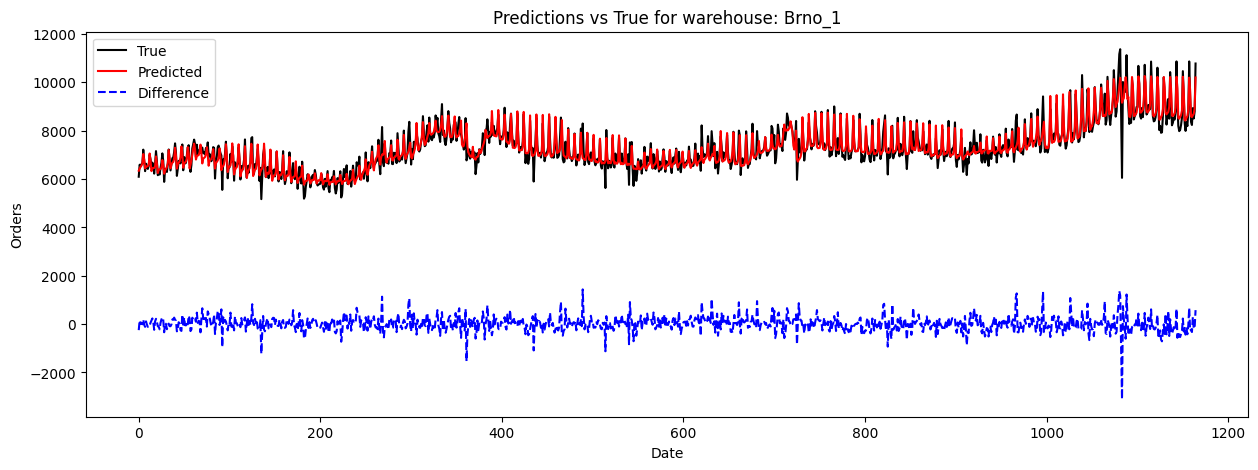


Mean Absolute Percentage Error for Brno_1: 3.0297%
Predicting for warehouse: Budapest_1
final shape: ((1126, 28, 41), (1126, 1))
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


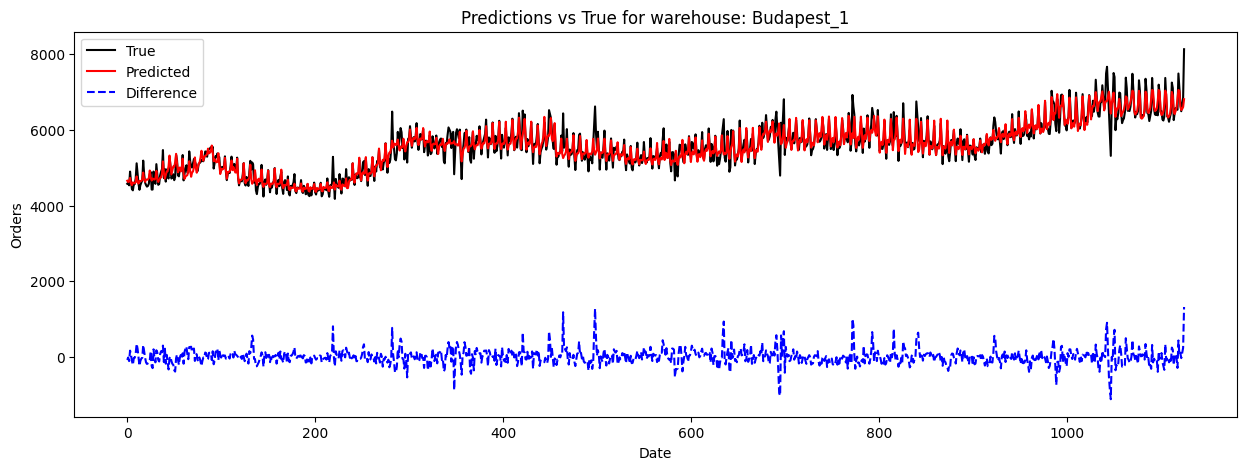


Mean Absolute Percentage Error for Budapest_1: 2.4850%
Predicting for warehouse: Prague_1
final shape: ((1165, 28, 41), (1165, 1))
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


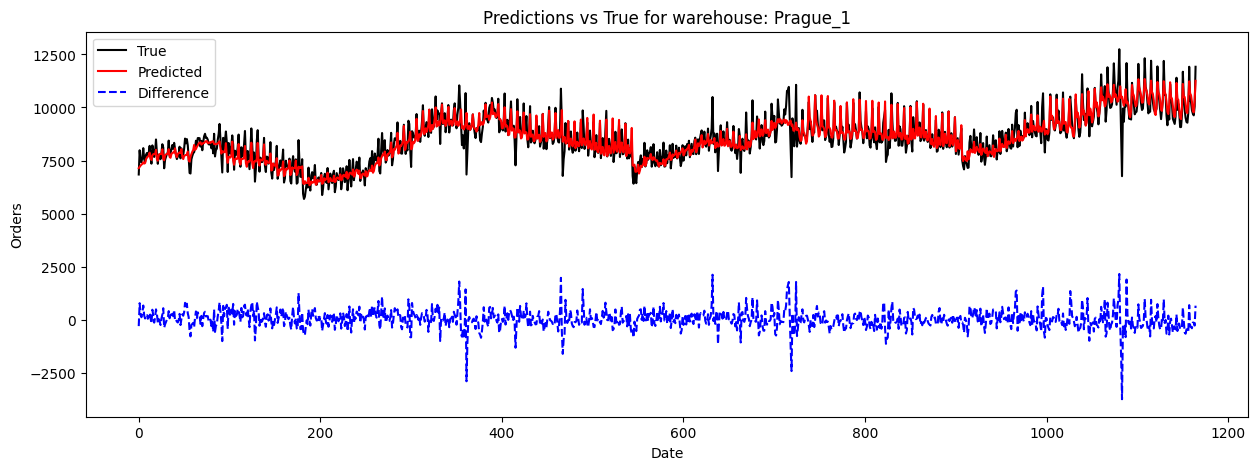


Mean Absolute Percentage Error for Prague_1: 3.6581%
Predicting for warehouse: Prague_2
final shape: ((1165, 28, 41), (1165, 1))
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


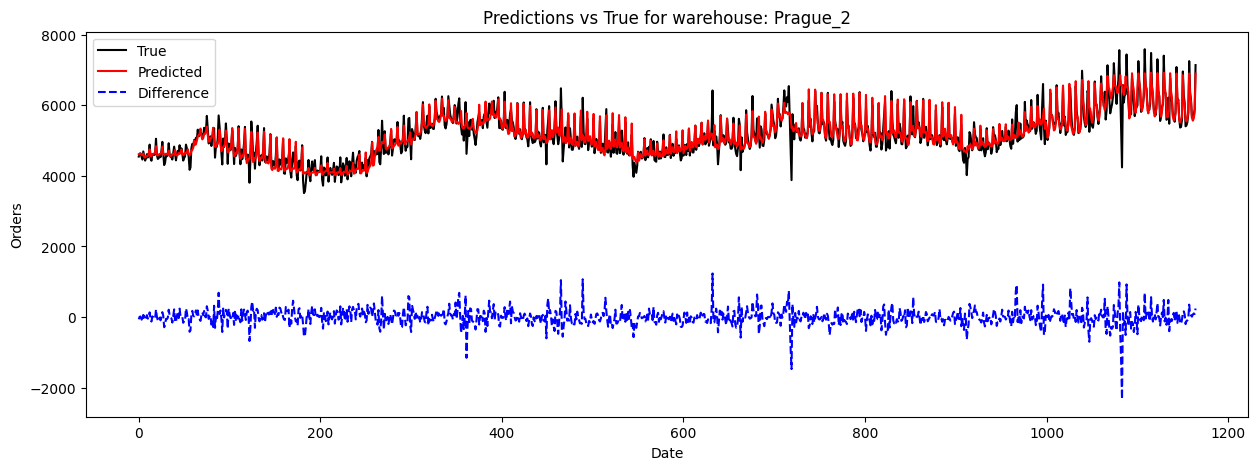


Mean Absolute Percentage Error for Prague_2: 3.0626%
Predicting for warehouse: Prague_3
final shape: ((1165, 28, 41), (1165, 1))
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


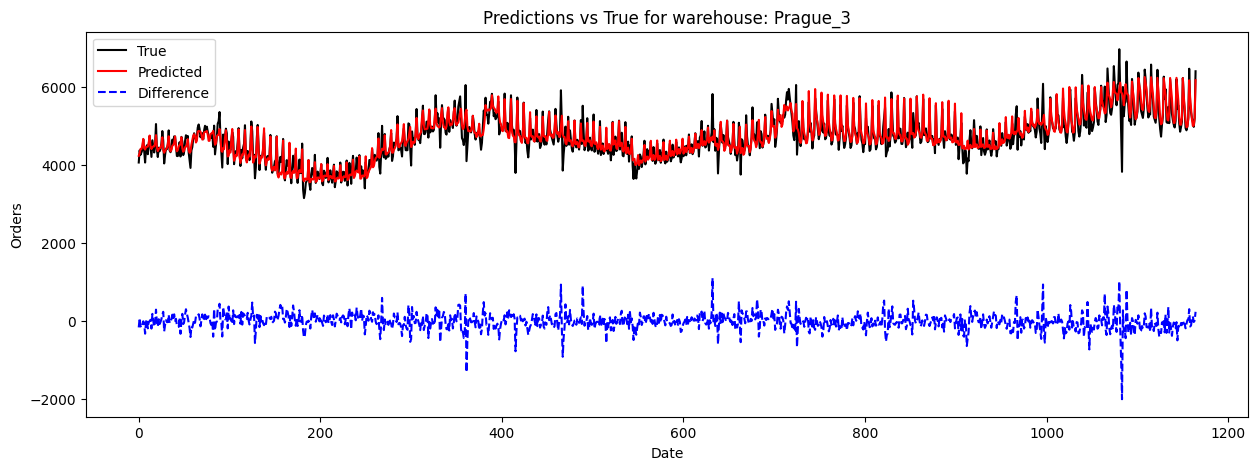


Mean Absolute Percentage Error for Prague_3: 3.2055%
Predicting for warehouse: Munich_1
final shape: ((757, 28, 41), (757, 1))
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


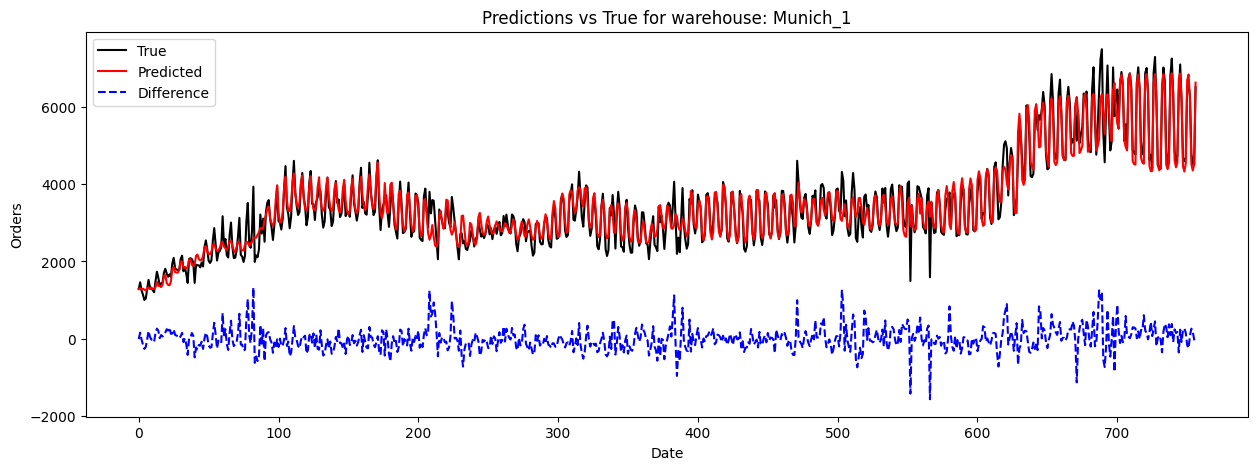


Mean Absolute Percentage Error for Munich_1: 6.8157%
Predicting for warehouse: Frankfurt_1
final shape: ((601, 28, 41), (601, 1))
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


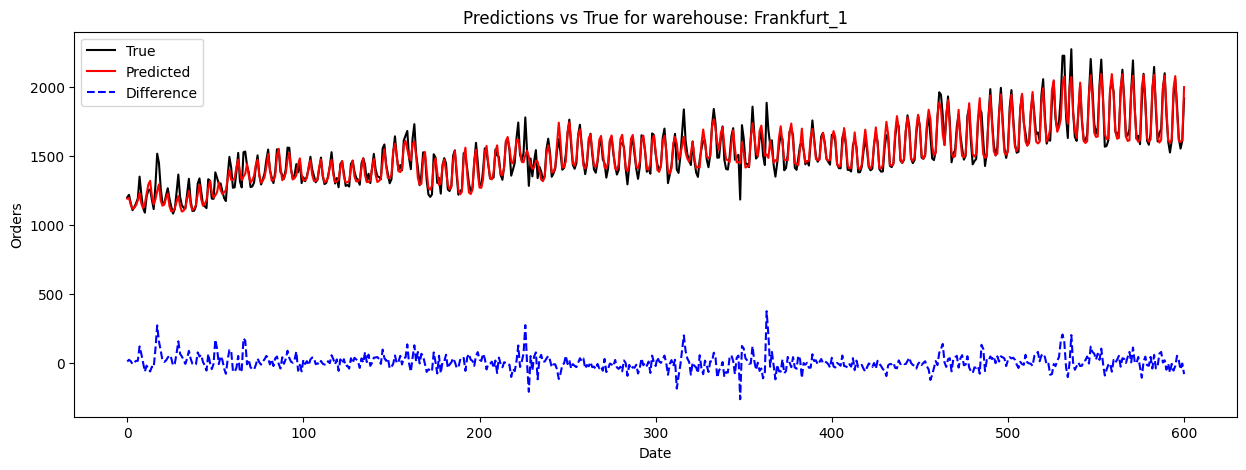


Mean Absolute Percentage Error for Frankfurt_1: 2.6724%

MAPE scores: 
Brno_1: 3.0297%
Budapest_1: 2.4850%
Prague_1: 3.6581%
Prague_2: 3.0626%
Prague_3: 3.2055%
Munich_1: 6.8157%
Frankfurt_1: 2.6724%

Mean MAPE: 3.5613%


In [54]:
# Predict and visualise MAPE for each warehouse with its model and scaler:
mape_scores = []

for warehouse in warehouses:
    print(f"Predicting for warehouse: {warehouse}")
    
    warehouse_data = train_df[train_df['warehouse'] == warehouse]
    
    X_train, y_train, x_scaler, y_scaler = preprocess_data(warehouse_data, warehouse)
    
    # Create sequences
    X_seq, y_seq = create_sequences(X_train, y_train, time_steps=28)
    
    # Load the model
    model = tf.keras.models.load_model(f'model_{warehouse}.keras')
    
    # Predict
    predictions = model.predict(X_seq)
    predictions = y_scaler.inverse_transform(predictions)
    y_seq_unscaled = y_scaler.inverse_transform(y_seq)
    
    # Calculate MAPE
    mape = mean_absolute_percentage_error(y_seq_unscaled, predictions) * 100
    mape_scores.append(mape)
    
    # Visualise the predictions
    plt.figure(figsize=(15, 5))
    plt.plot(y_seq_unscaled, label='True', color='black')
    plt.plot(predictions, label='Predicted', color='red')
    plt.plot(y_seq_unscaled - predictions, label='Difference', color='blue', linestyle='--')
    plt.title(f'Predictions vs True for warehouse: {warehouse}')
    plt.xlabel('Date')
    plt.ylabel('Orders')
    plt.legend()
    plt.show()
    
    print(f'\nMean Absolute Percentage Error for {warehouse}: {mape:.4f}%')

print("\nMAPE scores: ")
for i, score in enumerate(mape_scores):
    print(f"{warehouses[i]}: {score:.4f}%")

print(f"\nMean MAPE: {np.mean(mape_scores):.4f}%")   

## Inference:

In [69]:
dataframe = pd.read_csv("data/test_proc_mt.csv")
dataframe.head()

date    warehouse  holiday  shops_closed  winter_school_holidays  \
0  2024-03-16       Brno_1        0             0                       0   
1  2024-03-16   Budapest_1        0             0                       0   
2  2024-03-16  Frankfurt_1        0             0                       0   
3  2024-03-16     Munich_1        0             0                       0   
4  2024-03-16     Prague_1        0             0                       0   

   school_holidays                      id  quarter  year  month  day  \
0                0       Brno_1_2024-03-16        1  2024      3   16   
1                0   Budapest_1_2024-03-16        1  2024      3   16   
2                0  Frankfurt_1_2024-03-16        1  2024      3   16   
3                0     Munich_1_2024-03-16        1  2024      3   16   
4                0     Prague_1_2024-03-16        1  2024      3   16   

   day_of_week  day_of_year  is_weekend  days_since_start      year_sin  \
0            5           76           1              1197  3.208798e-11   
1            5           76           1              1197  3.208798e-11   
2            5           76           1              1197  3.208798e-11   
3            5           76           1              1197  3.208798e-11   
4            5           76           1              1197  3.208798e-11   

   year_cos     month_sin  month_cos  orders_lag_7  orders_lag_28  \
0    2024.0 -2.204364e-15        3.0        9419.0         9529.0   
1    2024.0 -2.204364e-15        3.0        7488.0         7193.0   
2    2024.0 -2.204364e-15        3.0        1930.0         1623.0   
3    2024.0 -2.204364e-15        3.0        6523.0         4499.0   
4    2024.0 -2.204364e-15        3.0       10344.0        10488.0   

   orders_lag_56  orders_lag_84  orders_lag_168  orders_lag_364  \
0         9512.0        11368.0          8045.0          7910.0   
1         7481.0         7492.0          5839.0          6047.0   
2         1652.0         1669.0          1427.0          1354.0   
3         5627.0         5067.0          3906.0          2448.0   
4        10968.0        10750.0          8806.0          9817.0   

   orders_rolling_mean_28  orders_rolling_std_28  orders_rolling_mean_168  \
0             8909.321429             951.304603              8743.699405   
1             6749.678571             526.409364              6531.068452   
2             1784.214286             192.741884              1737.220238   
3             5618.357143            1031.015760              5200.327381   
4            10081.250000             881.715736              9990.985119   

   orders_rolling_std_168  orders_rolling_mean_364  orders_rolling_std_364  
0              960.369783              7975.304945             1040.427470  
1              460.501368              6121.530220              550.190403  
2              198.875203              1621.207418              194.010902  
3             1184.786600              4153.747253             1319.545306  
4              943.277498              9228.081044             1080.219256

In [70]:
# load scaler config:
scaler_config = joblib.load('scaler_config.joblib') # load the scaler config
ohsc = joblib.load("scaler_onehot_categorical.joblib")   # OneHotEncoder for categorical features

scaler_columns = scaler_config['scaler_features']   # standard scaler features in the right order that the training dataset was scaled on
model_columns = scaler_config['model_features'] # training features in the right order that the model was trained on
cat_features = scaler_config['cat_features']    # categorical features
bin_features = scaler_config['bin_features']    # binary features are unpluged before scaling and then plugged back in after scaling
    
print(f"cat_features: {cat_features}")
print(f"binary_features: {bin_features}")
print(f"scaler_columns: {len(scaler_columns)}")

cat_features: ['day_of_week', 'quarter', 'year']
binary_features: ['is_weekend', 'holiday', 'shops_closed', 'winter_school_holidays', 'school_holidays']
scaler_columns: 36


In [57]:
# test data preprocessig function without lag, roll features and no "orders" influence:
def one_hot_encode(dataframe, ohsc, cat_col):

    # Encode categorical features
    encoded_categorical_features = ohsc.transform(dataframe[cat_col])
    encoded_feature_names = ohsc.get_feature_names_out(cat_col)
    dataframe_encoded = pd.DataFrame(encoded_categorical_features, columns=encoded_feature_names, index=dataframe.index)

    dataframe = pd.concat([dataframe, dataframe_encoded], axis=1)

    dataframe = dataframe.drop(columns=cat_col)
    
    return dataframe

In [58]:
id = dataframe['id']
date = dataframe['date']
warehouse = dataframe["warehouse"]

processed_data = one_hot_encode(dataframe, ohsc, cat_features)

In [59]:
processed_data.head()

date    warehouse  holiday  shops_closed  winter_school_holidays  \
0  2024-03-16       Brno_1        0             0                       0   
1  2024-03-16   Budapest_1        0             0                       0   
2  2024-03-16  Frankfurt_1        0             0                       0   
3  2024-03-16     Munich_1        0             0                       0   
4  2024-03-16     Prague_1        0             0                       0   

   school_holidays                      id  month  day  day_of_year  \
0                0       Brno_1_2024-03-16      3   16           76   
1                0   Budapest_1_2024-03-16      3   16           76   
2                0  Frankfurt_1_2024-03-16      3   16           76   
3                0     Munich_1_2024-03-16      3   16           76   
4                0     Prague_1_2024-03-16      3   16           76   

   is_weekend  days_since_start      year_sin  year_cos     month_sin  \
0           1              1197  3.208798e-11    2024.0 -2.204364e-15   
1           1              1197  3.208798e-11    2024.0 -2.204364e-15   
2           1              1197  3.208798e-11    2024.0 -2.204364e-15   
3           1              1197  3.208798e-11    2024.0 -2.204364e-15   
4           1              1197  3.208798e-11    2024.0 -2.204364e-15   

   month_cos  orders_lag_7  orders_lag_28  orders_lag_56  orders_lag_84  \
0        3.0        9419.0         9529.0         9512.0        11368.0   
1        3.0        7488.0         7193.0         7481.0         7492.0   
2        3.0        1930.0         1623.0         1652.0         1669.0   
3        3.0        6523.0         4499.0         5627.0         5067.0   
4        3.0       10344.0        10488.0        10968.0        10750.0   

   orders_lag_168  orders_lag_364  orders_rolling_mean_28  \
0          8045.0          7910.0             8909.321429   
1          5839.0          6047.0             6749.678571   
2          1427.0          1354.0             1784.214286   
3          3906.0          2448.0             5618.357143   
4          8806.0          9817.0            10081.250000   

   orders_rolling_std_28  orders_rolling_mean_168  orders_rolling_std_168  \
0             951.304603              8743.699405              960.369783   
1             526.409364              6531.068452              460.501368   
2             192.741884              1737.220238              198.875203   
3            1031.015760              5200.327381             1184.786600   
4             881.715736              9990.985119              943.277498   

   orders_rolling_mean_364  orders_rolling_std_364  day_of_week_0  \
0              7975.304945             1040.427470            0.0   
1              6121.530220              550.190403            0.0   
2              1621.207418              194.010902            0.0   
3              4153.747253             1319.545306            0.0   
4              9228.081044             1080.219256            0.0   

   day_of_week_1  day_of_week_2  day_of_week_3  day_of_week_4  day_of_week_5  \
0            0.0            0.0            0.0            0.0            1.0   
1            0.0            0.0            0.0            0.0            1.0   
2            0.0            0.0            0.0            0.0            1.0   
3            0.0            0.0            0.0            0.0            1.0   
4            0.0            0.0            0.0            0.0            1.0   

   day_of_week_6  quarter_1  quarter_2  quarter_3  quarter_4  year_2020  \
0            0.0        1.0        0.0        0.0        0.0        0.0   
1            0.0        1.0        0.0        0.0        0.0        0.0   
2            0.0        1.0        0.0        0.0        0.0        0.0   
3            0.0        1.0        0.0        0.0        0.0        0.0   
4            0.0        1.0        0.0        0.0        0.0        0.0   

   year_2021  year_2022  year_2023  year_2024  
0   

In [60]:
print(len(processed_data.columns))
print(len(scaler_columns))

44
36


In [61]:
# difference beterrn processed_data columns and scaler_columns
set(processed_data.columns).difference(set(scaler_columns))

{'date',
 'holiday',
 'id',
 'is_weekend',
 'school_holidays',
 'shops_closed',
 'warehouse',
 'winter_school_holidays'}

In [62]:
# Compare the columns in the original and processed dataframes

X_columns = set(X_train_df.columns)
processed_data_columns = set(processed_data.columns)

if X_columns == processed_data_columns:
    print("this df has the same columns as the training df.")
else:
    print("The dataframes have different columns.")

    columns_only_in_X = X_columns - processed_data_columns
    columns_only_in_processed_data = processed_data_columns - X_columns

    if columns_only_in_X:
        print("Columns present only in 'X_train' :")
        print(columns_only_in_X)

    if columns_only_in_processed_data:
        print("Columns present only in 'processed_data' :")
        print(columns_only_in_processed_data)

The dataframes have different columns.
Columns present only in 'processed_data' :
{'id', 'date', 'warehouse'}


In [63]:
# Load warehouse models and scalers
warehouses = processed_data['warehouse'].unique()
warehouse_models = {}
for wh in warehouses:
    model = tf.keras.models.load_model(f'model_{wh}.keras')
    x_scaler = joblib.load(f'x_scaler_{wh}.joblib')
    y_scaler = joblib.load(f'y_scaler_{wh}.joblib')
    warehouse_models[wh] = {'model': model, 'x_scaler': x_scaler, 'y_scaler': y_scaler}

In [64]:
def variable_length_predict(data, time_steps, warehouse_models, scaler_columns, binary_features, model_columns):
    predictions = []
    
    # Ensure data is sorted by date
    data = data.sort_values('date')
    
    for _, row in data.iterrows():
        wh = row['warehouse']
        
        if wh not in warehouse_models:
            print(f"No model found for warehouse: {wh}")
            predictions.append(np.nan)
            continue
        
        model = warehouse_models[wh]['model']
        x_scaler = warehouse_models[wh]['x_scaler']
        y_scaler = warehouse_models[wh]['y_scaler']
        
        # Get data for this warehouse up to this point
        wh_data = data[data['warehouse'] == wh]
        wh_data = wh_data[wh_data['date'] <= row['date']]
        
        # Remove binary features before scaling
        binary_data = wh_data[binary_features]
        scale_data = wh_data[scaler_columns]
        
        # Scale the data
        scaled_data = x_scaler.transform(scale_data)
        
        # Add binary features back
        scaled_data = np.column_stack((scaled_data, binary_data))
        
        # Ensure columns are in the correct order
        scaled_df = pd.DataFrame(scaled_data, columns=scaler_columns + binary_features)
        scaled_df = scaled_df[model_columns]
        
        # Prepare data for prediction
        series_data = scaled_df.values
        
        # Handle case where we don't have enough data
        if len(series_data) < time_steps:
            # Pad the data with the first row repeated
            padding = np.tile(series_data[0], (time_steps - len(series_data), 1))
            series_data = np.vstack((padding, series_data))
        
        # Use the last `time_steps` rows for prediction
        last_sequence = series_data[-time_steps:].reshape(1, time_steps, -1)
        
        # Make prediction
        pred = model.predict(last_sequence)
        
        # Inverse transform the prediction
        pred_rescaled = y_scaler.inverse_transform(pred)
        predictions.append(pred_rescaled[0][0])
    
    return np.array(predictions)

In [65]:
# Process each warehouse
time_steps = 28
feature_columns = [col for col in processed_data.columns if col not in ['id', 'date', 'warehouse']]
predictions = variable_length_predict(processed_data, time_steps, warehouse_models, 
                                      scaler_columns, binary_features, model_columns)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━

In [66]:
# Create submission DataFrame
submission_df = pd.DataFrame({
    'id': id,
    'orders': predictions,
    'date': date,
    'warehouse': warehouse
})

# Save submission CSV
submission_df.to_csv('submission_multi_warehouse.csv', index=False)

In [67]:
# Ensure 'date' column is datetime
submission_df['date'] = pd.to_datetime(submission_df['date'])
train_df_raw['date'] = pd.to_datetime(train_df_raw['date'])

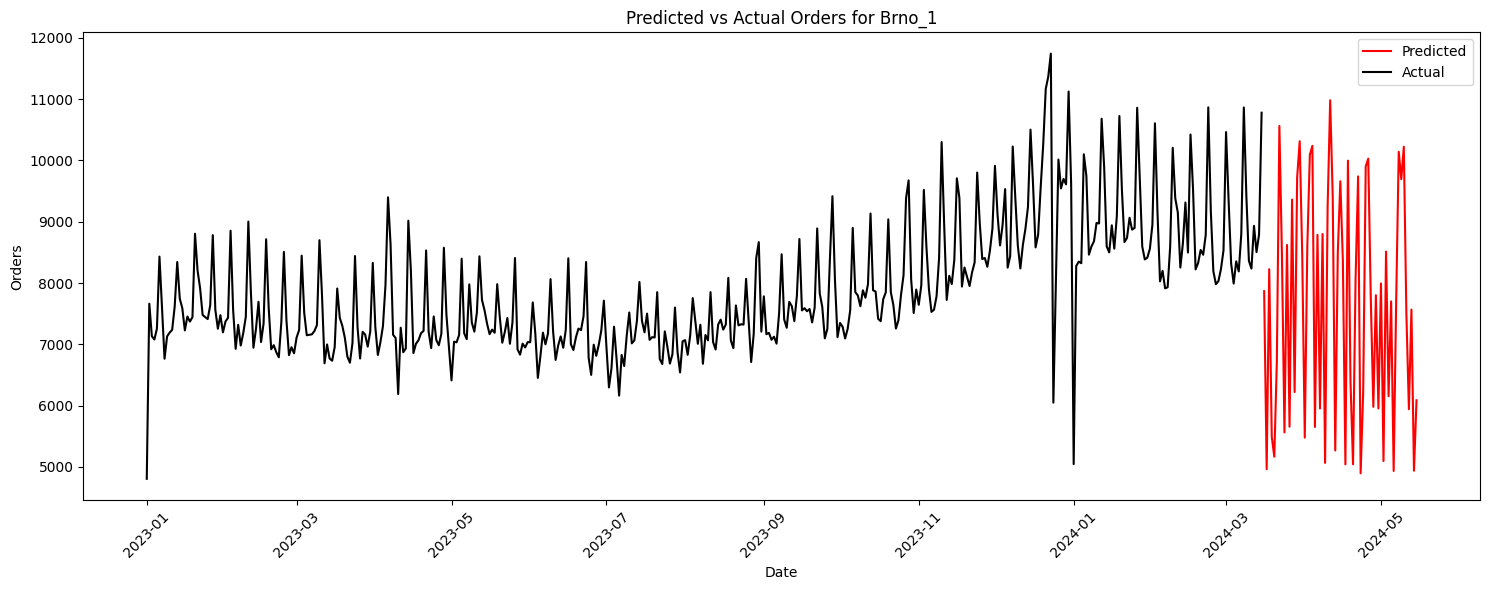

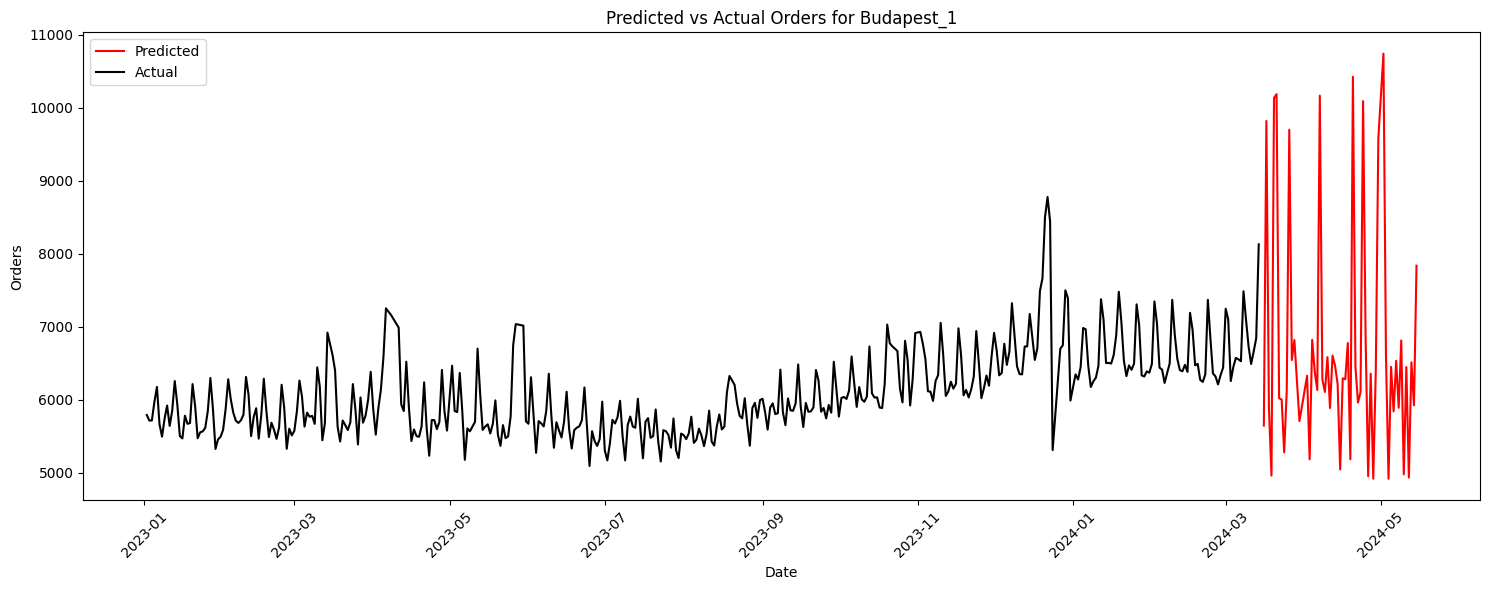

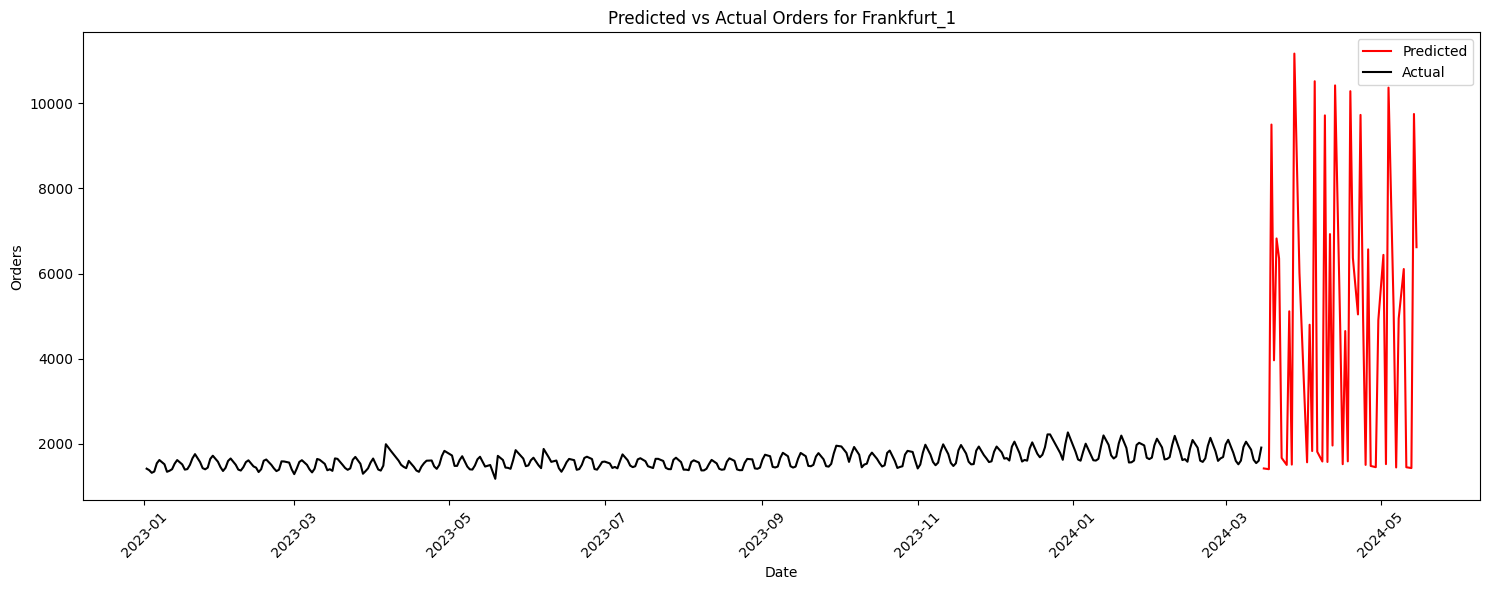

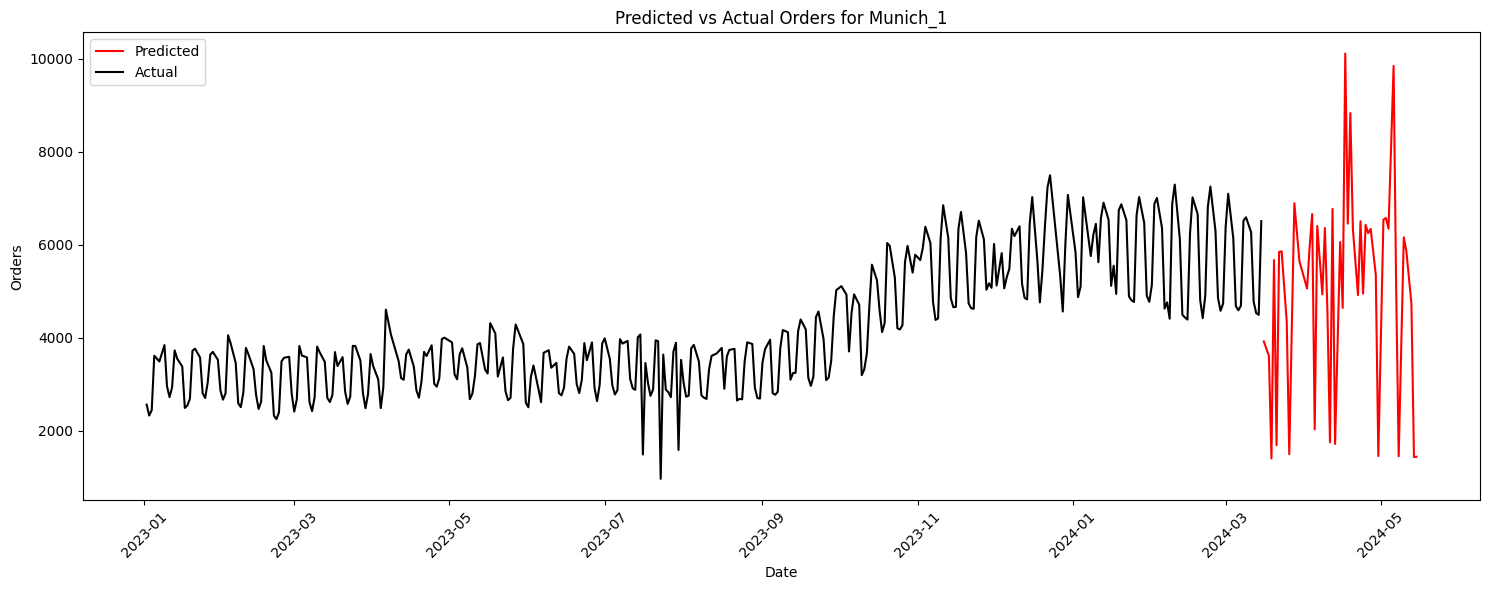

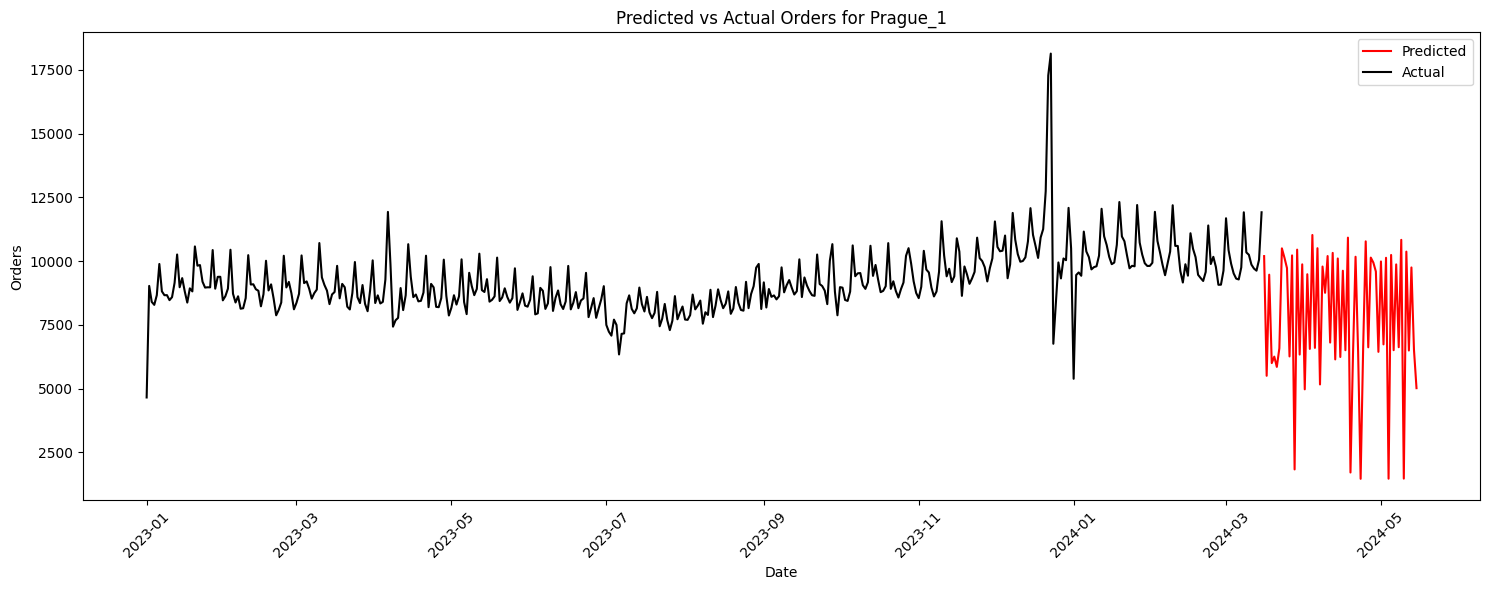

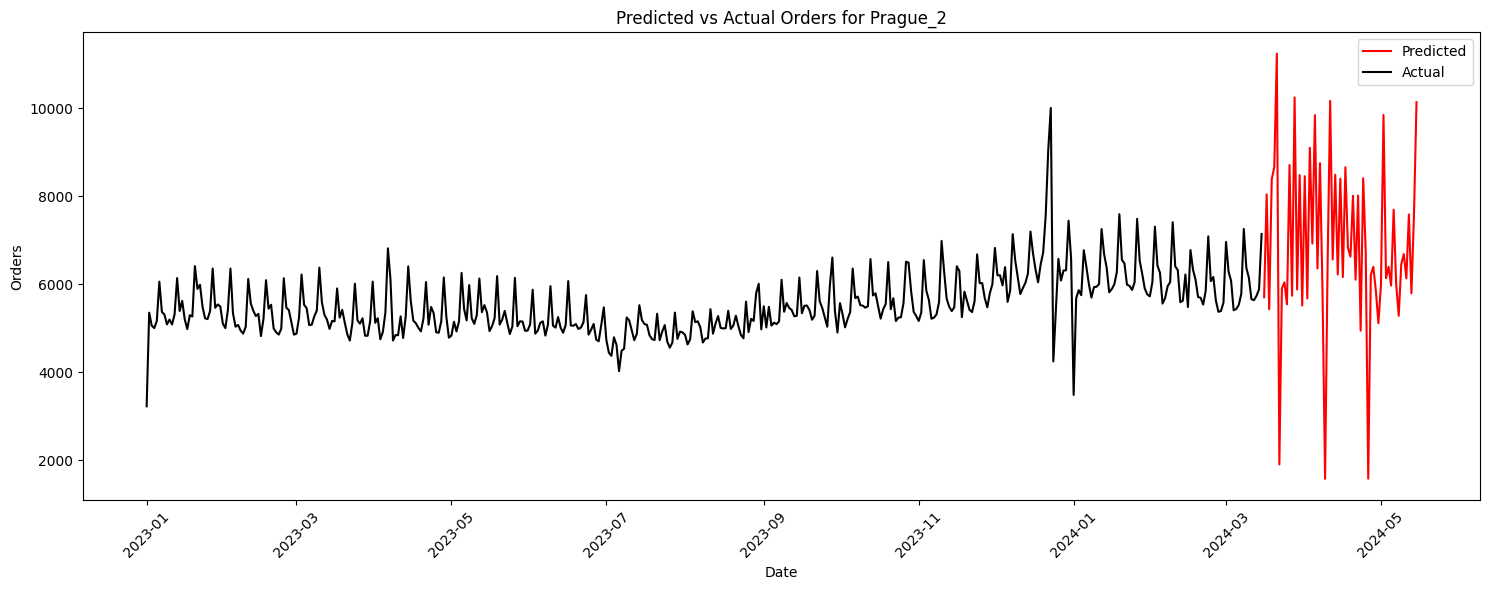

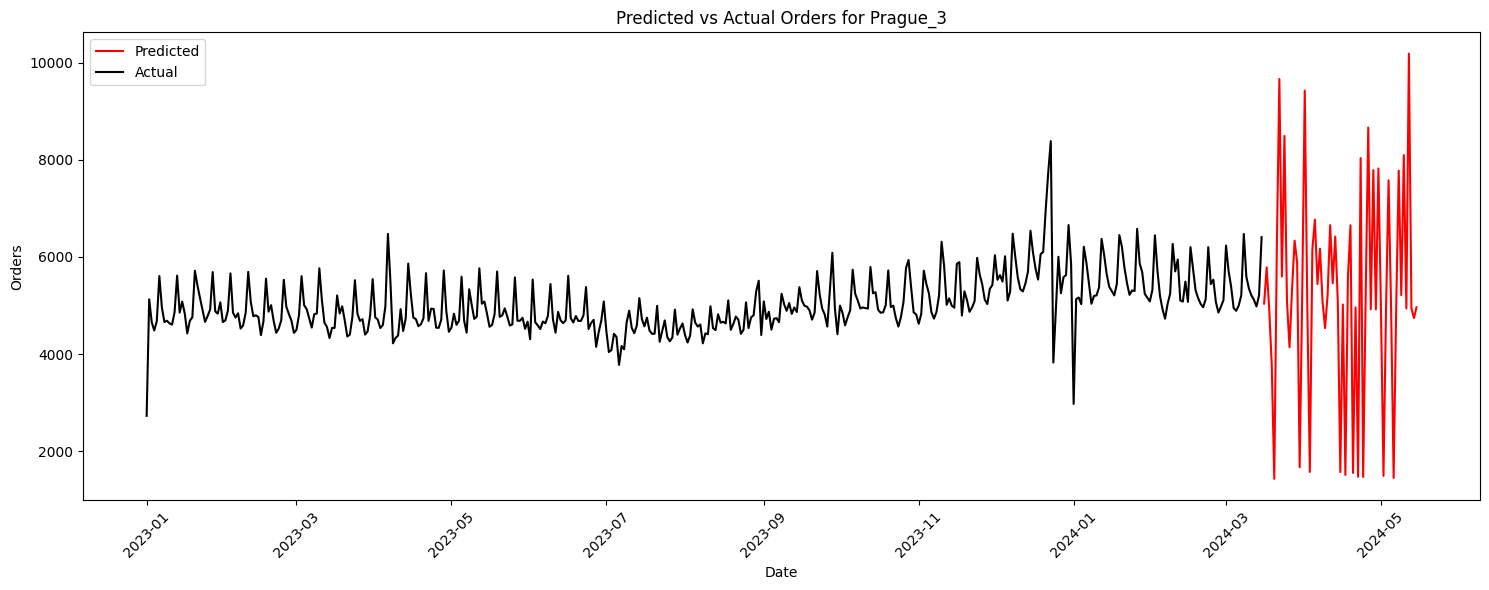

Predictions complete. Submission file and plots created.


In [68]:
# Plot predictions for each warehouse
for wh in warehouses:
    plt.figure(figsize=(15, 6))
    
    # Plot predicted data
    wh_df = submission_df[submission_df['warehouse'] == wh]
    plt.plot(wh_df['date'], wh_df['orders'], label='Predicted', color='red')
    
    # Plot actual data (training data from 2023)
    wh_df_train = train_df_raw[(train_df_raw['warehouse'] == wh) & (train_df_raw['date'].dt.year >= 2023)]
    plt.plot(wh_df_train['date'], wh_df_train['orders'], label='Actual', color='black')
    
    plt.title(f'Predicted vs Actual Orders for {wh}')
    plt.xlabel('Date')
    plt.ylabel('Orders')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'prediction_plot_{wh}.png')
    plt.show()
    plt.close()

print("Predictions complete. Submission file and plots created.")